# Imports

In [1]:
import yfinance as yf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.preprocessing import MinMaxScaler

import datetime
from datetime import date

2024-08-25 17:49:48.393854: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-25 17:49:48.396738: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-25 17:49:48.405945: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-25 17:49:48.420825: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-25 17:49:48.425391: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-25 17:49:48.437733: I tensorflow/core/platform/cpu_feature_gu

# Constantes

In [2]:

# callbacks
early_stopping = EarlyStopping(monitor="val_loss",
                                min_delta = 0.0001,
                                patience = 8,
                                verbose=1,
                                restore_best_weights = True)

reduce_learning_rate = ReduceLROnPlateau(monitor="val_loss",
                                            patience = 5,
                                            factor = 0.0001,
                                            cooldown = 3,
                                            verbose=1,min_lr = 1e-6)

# Fonctions ( à intégrer ensuite en py)

In [3]:
# fonction pour convertir les données en format de séquence:

def create_dataset(array, pas_temps):
    X = []  
    y = []
    for i in range(array.shape[0]-pas_temps-1):
        a = array[i:(i+pas_temps), 0]              
        X.append(a)                             
        y.append(array[i+pas_temps,0])                
    return np.array(X),np.array(y) 


# Pour un tableau de 100 lignes :

# SI pas =1 #1er on prend les données data[0:1,0], c'est à dire la ligne 1 de la première colonne on les mets dans X, puis on met data[1] dans Y c'est à dire la seconde ligne
# On se sert donc d'une ligne pour prédire la ligne suivante 
# On va jusqu'à prédire la 99eme à l'aide de la ligne 98

# Si pas = 2 : #1er on prend les données data[0:2,0], c'est à dire les lignes 1 et 2 de la première colonne, on injecte dans la première entrée de la liste
# Ensuite on met data[2] dans Y c'est à dire la trosième ligne
# On se sert donc de deux lignes  pour prédire la ligne suivante  
# On va jusqu'à prédire la 99eme ligne avec les deux lignes précédentes (donc l'avant dernière ligne)   
   
# En résumé, le paramètre pas_temps spécifie le nombre de pas de temps passés à utiliser comme entrée pour prédire la sortie. Plus la valeur de pas_temps est grande,
# plus le modèle sera capable de capturer des tendances à long terme dans les données, mais il sera également plus sensible aux variations à court terme. Inversement, une valeur plus
# petite de pas_temps permettra au modèle de réagir plus rapidement aux changements dans les données, mais il sera moins capable de capturer des tendances à long terme.


In [3]:
def load_data(ticker, start = "2014-07-01", end = "2024-08-01", interval = "1d", start_new_data = "2024-08-01"):
    """
    
    """
    try:       
        #Teléchargement via l'API yfinance
        #données dentrainement
        currency= yf.Ticker(ticker)       
        currency_historical = currency.history(start=start, end = end, interval = interval, auto_adjust = True)
        
        #ajouter nouvelles données
        today = date.today()
        today_date = today.isoformat() # on va récupérer les données jusqu'à celle d'hier
        yesterday = today - datetime.timedelta(days=1)

        currency_new_data = currency.history(start=start_new_data, end =  yesterday, interval = interval, auto_adjust = True)
      
        return pd.concat([currency_historical, currency_new_data], ignore_index=True) # new_data is appended to reference_data without Outcome
    
    except Exception as e:
        print(f"Error loading data: {e}")
        return pd.DataFrame()   #df concaténé
    
def load_tranform_data(period,ticker): 
       
    df = load_data(ticker=ticker, start = "2014-07-01", end = "2024-08-01", interval = period, start_new_data = "2024-08-01")
    print("Chargement des données effectué")
    
    # Data Normalization
    df_array, df_index, scaler = normalize_data(df= df, period=period)
    print("Normalisation des données effectuée")
    
    return df_array, df.index, scaler

def normalize_data(df, period):
    """
    Standardise numerical features of a DataFrame and remove some columns
    :param df: pd.DataFrame
    :columns: list of non used columns for the price prediction, which are removed
    :return: np.Array with standardized values
    """ 
    
    # removal of useless columns 
    if period == '1d':
        df =df.drop(columns= ['Open','High','Low','Dividends','Stock Splits','Volume'], axis=1)
    else :
        df =df.drop(columns=['Open','High','Low','Volume'], axis=1)    
    
    # recupération de l'index (à voir ensuite si utile)
    df_index = df.index
    
    #tf en tableau numpy
    df_array = np.array(df)
    
    #instanciation du Scaler et normalisation
    scaler=MinMaxScaler(feature_range=(0,1))    
    scaled_data = scaler.fit_transform (df_array)

    return scaled_data, df_index, scaler




In [3]:
import os
import sys
from os.path import dirname, join, normpath, abspath

# Récupérer le chemin d'accès du répertoire courant du dossier
current_dir = os.getcwd()
# Accéder au répertoire parent en utilisant os.pardir
parent_current_dir = abspath(os.path.join(current_dir, os.pardir))


SRC_DIR = normpath(join(parent_current_dir, 'src'))
SCRIPTS_DIR = normpath(join(parent_current_dir, 'scripts'))


#ajout du chemin dans sys
sys.path.append(parent_current_dir)
sys.path.append(SRC_DIR)
sys.path.append(SCRIPTS_DIR)


def prepare_sequential_data(data, pas_temps):
    """
    Create an Array with adequate train and target sequences on the basis of original data.
    :param pas_temps: number of previous days used for LSTM prediction
    :param data: Standardized np.array
    """
    # Emply lists creation
    X = []  
    y = []
    
    #filling lists
    for i in range(data.shape[0]-pas_temps-1):
        a = data[i:(i+pas_temps), 0]   
        X.append(a)                             
        y.append(data[i+pas_temps, 0])
              
    return np.array(X),np.array(y) 

In [12]:
def prepare_sequential_data(data, pas_temps):
    """
    Create an Array with adequate train and target sequences on the basis of original data.
    :param pas_temps: number of previous days used for LSTM prediction
    :param data: Standardized np.array
    """
    # Emply lists creation
    X = []  
    y = []
    
    #filling lists
    for i in range(data.shape[0]-pas_temps):
        a = data[i:(i+pas_temps), 0]   
        X.append(a)                             
        y.append(data[i+pas_temps, 0])
              
    return np.array(X),np.array(y)

In [24]:
from mlflow import MlflowClient

exp_name = "Projet_Bitcoin_price_prediction"

tracking_uri= "http://0.0.0.0:8080"

client = MlflowClient(tracking_uri=tracking_uri) 
# Vérify is experiment exist

In [27]:
pd.DataFrame({
        'Open': [100, 200],
        'High': [110, 210],
        'Low': [90, 190],
        'Close': [105, 205],
        'Volume': [1000, 1500],
        'Dividends': [0, 0],
        'Stock Splits': [0, 0]})

,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,100,110,90,105,1000,0,0
1,200,210,190,205,1500,0,0


In [28]:
def normalize_data(df, period):
    """
    Standardise numerical features of a DataFrame and remove some columns
    :param df: pd.DataFrame
    :columns: list of non used columns for the price prediction, which are removed
    :return: np.Array with standardized values
    """ 
    
    # removal of useless columns 
    if period == '1d':
        df =df.drop(columns= ['Open','High','Low','Dividends','Stock Splits','Volume'], axis=1)
    else :
        df =df.drop(columns=['Open','High','Low','Volume'], axis=1)    
    
    # recupération de l'index (à voir ensuite si utile)
    df_index = df.index
    
    #tf en tableau numpy
    df_array = np.array(df)
    
    #instanciation du Scaler et normalisation
    scaler=MinMaxScaler(feature_range=(0,1))    
    scaled_data = scaler.fit_transform (df_array)

    return scaled_data, df_index, scaler

In [41]:
df1 = pd.DataFrame({'Open': [400, 500, 600, 700],
        'High': [4200, 355, 520, 700],
        'Low': [350,450,390, 700],
        'Close': [410, 789, 589, 700],
        'Volume': [1000, 1200, 1500, 700],
        'Dividends': [0,0,0,0],
        'Stock Splits': [0,0,0,0]
        })
df1

,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,400,4200,350,410,1000,0,0
1,500,355,450,789,1200,0,0
2,600,520,390,589,1500,0,0
3,700,700,700,700,700,0,0


In [44]:
scaled_data, df_index, scaler = normalize_data(df1,'1d')
print(scaled_data.shape)

(4, 1)


In [45]:
scaled_data

array([[0.        ],
       [1.        ],
       [0.47229551],
       [0.7651715 ]])

In [39]:
df2= pd.DataFrame({'Open': [400, 500, 600, 700, 800, 250],
        'High': [400, 355, 520, 700, 800, 900],
        'Low': [350, 450,390, 700, 560, 650],
        'Close': [410, 789, 589, 700, 800, 900],
        'Volume': [1000, 1200, 1500, 700, 800, 900],
        'Dividends': [0,0,0,0,1,0],
        'Stock Splits': [0,0,0,0,0,1]})
df2.shape

(6, 7)

In [46]:
scaled_data, df_index, scaler = normalize_data(df2,'1d')
print(scaled_data.shape)

(6, 1)


In [47]:
scaled_data

array([[0.        ],
       [0.77346939],
       [0.36530612],
       [0.59183673],
       [0.79591837],
       [1.        ]])

In [50]:
np.all((scaled_data <= 1))

False

In [51]:
scaled_data[-1,:]

array([1.])

In [37]:
np.allclose?

Signature:       np.allclose(a, b, rtol=1e-05, atol=1e-08, equal_nan=False)
Call signature:  np.allclose(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <function allclose at 0x7effed3af420>
File:            ~/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/numpy/core/numeric.py
Docstring:      
Returns True if two arrays are element-wise equal within a tolerance.

The tolerance values are positive, typically very small numbers.  The
relative difference (`rtol` * abs(`b`)) and the absolute difference
`atol` are added together to compare against the absolute difference
between `a` and `b`.

NaNs are treated as equal if they are in the same place and if
``equal_nan=True``.  Infs are treated as equal if they are in the same
place and of the same sign in both arrays.

Parameters
----------
a, b : array_like
    Input arrays to compare.
rtol : float
    The relative tolerance parameter (see Notes).
atol : float
    The absolute tolera

In [36]:
np.allclose(scaled_data, np.array([[0], [1]]))  # Vérifie que les données sont bien normalisées


ValueError: operands could not be broadcast together with shapes (6,1) (2,1) 

In [8]:
def load_transform_data(period,ticker): 
       
    df = load_data(ticker=ticker, start = "2014-07-01", end = "2024-08-01", interval = period, start_new_data = "2024-08-01")
    print("Chargement des données effectué")
    
    # Data Normalization
    df_array, df_index, scaler = normalize_data(df= df, period=period)
    print("Normalisation des données effectuée")
    
    return df_array, df.index, scaler

def load_best_model(exp_name, model_name, model_version, period, tracking_uri, metric_name = "mean_squarred_error_test", order='ASC'):
    #client
    client = MlflowClient(tracking_uri = tracking_uri)
             
    # Check and obtain experiment
    experiment = get_check_experiment(exp_name, tracking_uri)
            
    # Get experiment ID
    experiment_id = experiment.experiment_id
    
    # Search for all runs
    runs = client.search_runs(experiment_id, order_by=[f"metrics.{metric_name} {order}"])
        
    model_uri = f"models:/{model_name}/{model_version}"
    #model_uri = f"mlruns/{experiment_id}/{run_id}/artifacts/tf-lstm-reg-model-{period}"
        
    try:
        best_model = mlflow.tensorflow.load_model(model_uri =model_uri)        
    except mlflow.exceptions.MlflowException as e: 
        print(f"aucun modèle enregistré n'a été trouvé dans model_uri : {model_uri}. Erreur: {e}")
        best_model = None  # Retourner None ou une valeur par défaut en cas d'erreur
        
    return best_model

def load_data(ticker, start = "2014-07-01", end = "2024-08-01", interval = "1d", start_new_data = "2024-08-01"):
    """
    
    """
    try:       
        #Teléchargement via l'API yfinance
        #données dentrainement
        currency= yf.Ticker(ticker)       
        currency_historical = currency.history(start=start, end = end, interval = interval, auto_adjust = True)
        
        #ajouter nouvelles données
        today = date.today()
        today_date = today.isoformat() # on va récupérer les données jusqu'à celle d'hier
        yesterday = today - datetime.timedelta(days=1)

        currency_new_data = currency.history(start=start_new_data, end =  yesterday, interval = interval, auto_adjust = True)
      
        return pd.concat([currency_historical, currency_new_data], ignore_index=True) # new_data is appended to reference_data without Outcome
    
    except Exception as e:
        print(f"Error loading data: {e}")
        return pd.DataFrame()   # df concaténé

def normalize_data(df, period):
    """
    Standardise numerical features of a DataFrame and remove some columns
    :param df: pd.DataFrame
    :columns: list of non used columns for the price prediction, which are removed
    :return: np.Array with standardized values
    """ 
    
    # removal of useless columns 
    if period == '1d':
        df =df.drop(columns= ['Open','High','Low','Dividends','Stock Splits','Volume'], axis=1)
    else :
        df =df.drop(columns=['Open','High','Low','Volume'], axis=1)    
    
    # recupération de l'index (à voir ensuite si utile)
    df_index = df.index
    
    #tf en tableau numpy
    df_array = np.array(df)
    
    #instanciation du Scaler et normalisation
    scaler=MinMaxScaler(feature_range=(0,1))    
    scaled_data = scaler.fit_transform (df_array)

    return scaled_data, df_index, scaler

In [14]:
import mlflow
from mlflow import MlflowClient

def get_check_experiment(exp_name, tracking_uri):
    """
    Check if an experiment exist with an exp_name
    - args : exp_nam (str) : experience name
    return :
    experiment object
    """    
    client = MlflowClient(tracking_uri=tracking_uri) 
    # Vérify is experiment exist

    experiment = client.get_experiment_by_name(exp_name)
    
    if experiment is None:
        print(f"Aucune expérience trouvée avec le nom '{exp_name}'.")
        return None
    else:
        return experiment 

In [26]:
pas_temps = 1            
batch_size = 5

# recupérer les arguments
ticker = 'BTC-EUR'
period = '5d'

# scripts variables
exp_name = "Projet_Bitcoin_price_prediction"
run_name = "first_run"  
tracking_uri = "http://0.0.0.0:5000"

model_name = f"tf-lstm-reg-model-{period}"
model_version = "latest"
 
# MLflow Tracking client
client = MlflowClient(tracking_uri= tracking_uri) 
   
#load_tranform
X_test, df_index, scaler = load_transform_data(period = period,ticker = ticker)

#load best_model
try:
    best_model = load_best_model(period = period, exp_name = exp_name, model_name =model_name, model_version = model_version, tracking_uri = tracking_uri)
except Exception as e:
    print(e)

if best_model is not None:
    test_predict = best_model.predict(X_test)
else:
    print("Le modèel n'a pas été chargé)")
    
#scaling
test_predict = test_predict/scaler.scale_[0]
X_test = X_test/scaler.scale_[0]

print(f"La valeur du Bitcoin était de {int(X_test[-1])} {ticker} hier à la fermeture. Le modèle prédit une valeur de {test_predict[-1]} {ticker} ")
    

Chargement des données effectué
Normalisation des données effectuée
aucun modèle enregistré n'a été trouvé dans model_uri : models:/tf-lstm-reg-model-5d/latest. Erreur: Registered Model with name=tf-lstm-reg-model-5d not found
Le modèel n'a pas été chargé)


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/mlflow/store/artifact/utils/models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


NameError: name 'test_predict' is not defined

In [27]:
arr = np.array([[1], [2], [3], [4], [5], [6], [7], [8], [9], [10]])

In [31]:
arr[-1,0]

10

In [18]:
experiment == None

False

In [ ]:
print(ls)

None


In [26]:
import mlflow
print(mlflow.list_experiments())

AttributeError: module 'mlflow' has no attribute 'list_experiments'

In [25]:
# Obtain the experiment
ls= get_check_experiment(exp_name, tracking_uri)

Aucune expérience trouvée avec le nom 'Projet_Bitcoin_price_prediction'.


In [32]:
registered_best_model?

Type:        RegisteredModel
String form: <RegisteredModel: aliases={}, creation_timestamp=1724140574006, description='', last_updated_time <...> DY', status_message='', tags={}, user_id='', version='2'>], name='tf-lstm-reg-model-1d', tags={}>
File:        ~/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/mlflow/entities/model_registry/registered_model.py
Docstring:   MLflow entity for Registered Model.

In [5]:
def build_lstm_model(neurons,input_shape = (None,1), activ_func= "relu", loss='mse', metrics= ['mse'], optimizer='adam'):
    """
    Build LSTM model with a given number of neurons and Dense layer for regression prediction
    :param neurons: number of neurons (int>0)
    :param input_shape: Shape of the Input after sequencing of historical prices
    :param activ_func: activation function
    :param loss: loss function used during training
    :param metrics name: metrics showed during training
    :param optimizer: optimizer used during compiling
    :return: LSTM model
    """
    model = Sequential()
    model.add(LSTM(neurons,input_shape=input_shape,activation=activ_func))  
    model.add(Dense(1))
    model.compile(loss=loss, metrics= metrics, optimizer=optimizer)
    return model


In [33]:
 client.set_registered_model_alias?

Signature: client.set_registered_model_alias(name: str, alias: str, version: str) -> None
Docstring:
Set a registered model alias pointing to a model version.

Args:
    name: Registered model name.
    alias: Name of the alias. Note that aliases of the format ``v<number>``, such as
        ``v9`` and ``v42``, are reserved and cannot be set.
    version: Registered model version number.

.. code-block:: Python
    :caption: Example

    import mlflow
    from mlflow import MlflowClient
    from mlflow.models import infer_signature
    from sklearn.datasets import make_regression
    from sklearn.ensemble import RandomForestRegressor


    def print_model_info(rm):
        print("--Model--")
        print("name: {}".format(rm.name))
        print("aliases: {}".format(rm.aliases))


    def print_model_version_info(mv):
        print("--Model Version--")
        print("Name: {}".format(mv.name))
        print("Version: {}".format(mv.version))
        print("Aliases: {}".format(mv.aliases

In [7]:
def normalize_data(df, columns):
    """
    Standardise numerical features of a DataFrame and remove some columns
    :param df: pd.DataFrame
    :columns: list of non used columns for the price prediction, which are removed
    :return: np.Array with standardized values
    """    
    # removal of non useless columns    
    df =df.drop(columns=columns, axis=1)
    
    # recupération de l'index (à voir ensuite si utile)
    df_index = df.index
    
    #tf en tableau numpy
    df_array = np.array(df)
    
    #instanciation du Scaler et normalisation
    scaler=MinMaxScaler(feature_range=(0,1))    
    scaled_data = scaler.fit_transform (df_array)
    
    print("Standardisation effectuée")

    return scaled_data, df_index, scaler, "Normalization"

In [9]:
def prepare_sequential_data(data, pas_temps):
    """
    Create an Array with adequate train and target sequences, on the basis of original data.
    :param pas_temps: number of previous days used for prediction
    :param data: Standardized np.array
    """
    X = []  
    y = []
    for i in range(data.shape[0]-pas_temps-1):
        a = data[i:(i+pas_temps), 0]   
        X.append(a)                             
        y.append(data[i+pas_temps, 0])             
    return np.array(X),np.array(y) 


def make_dataset(data,pas_temps,test_size=0.3):
    """
    Split data into train and test data. Create sequecial data for LSTM model, with parameter pas_temps.
    :param data: Standardized np.array
    :param test_size: fraction size of the test data
    :param pas_temps: number of previous days to incorporate in the training sequence
    :return: np.Array with standardized values
    """
    #Train and test data split
    size = int(len(data)*(1-test_size))
    train_data, test_data = data[:size,:], data[size:,:]
 
    
    #Création des ensembles d'entrainement et de la cible en format de séquence:
    X_train, y_train = prepare_sequential_data(data=train_data,pas_temps=pas_temps)
    X_test, y_test = prepare_sequential_data(data=test_data,pas_temps=pas_temps)
    
    #mise en forme des données pour le réseau LSTM
    X_train =X_train.reshape(X_train.shape[0],X_train.shape[1],1)
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
    
    return X_train, X_test, y_train, y_test

In [10]:
def train_LSTM_model(X_train, y_train, X_test, y_test, neurons, pas_temps, batch_size = 10):
    """
    """ 
    # Enregistrer l'heure de début
    start_time = datetime.datetime.now()
    
    #construction du model
    model = build_lstm_model(neurons=neurons)
    
    #entrainement du modèle
    history = model.fit(X_train, y_train,
                        batch_size= 10,
                        epochs=100, verbose=0,
                        validation_data = [X_test, y_test],
                        callbacks=[reduce_learning_rate, early_stopping])
   
    # Enregistrer l'heure de fin
    end_time = datetime.datetime.now()
    # Calculer la durée
    duration = end_time - start_time
    duration_seconds = duration.total_seconds()
    
    # Afficher la durée
    print(f"Temps passé pour un pas de temps de {pas_temps} jour et un nombre de neurones de {neurons} :", duration_seconds, "secondes")
        
    return history,duration_seconds,model
    

In [11]:
def predict(X_train, y_train, X_test, y_test, scaler, model):
    
    #prédiction et remise à l'échelle X
    train_predict = model.predict(X_train)
    train_predict_valeurs_reelles = train_predict/scaler.scale_[0]
    
    test_predict = model.predict(X_test)
    test_predict_valeurs_reelles = test_predict/scaler.scale_[0]
    
    #prédiction et remise à l'échelle y
    y_train = y_train.reshape(-1,1)
    y_train_valeurs_reelles = y_train /scaler.scale_[0]
    
    y_test = y_test.reshape(-1,1)
    y_test_valeurs_reelles = y_test/scaler.scale_[0]    
    
    return train_predict, y_train, test_predict,y_test

In [16]:
def evaluate(train_predict_valeurs_reelles, y_train_valeurs_reelles, test_predict_valeurs_reelles,y_test_valeurs_reelles):
    
    #train
    rmse_train = np.sqrt(mean_squared_error(y_train_valeurs_reelles,train_predict_valeurs_reelles))
    mse_train = mean_squared_error(y_train_valeurs_reelles,train_predict_valeurs_reelles)
    mae_train = mean_absolute_error(y_train_valeurs_reelles,train_predict_valeurs_reelles)
    explained_variance_train = explained_variance_score(y_train_valeurs_reelles,train_predict_valeurs_reelles)
    r2_score_train = r2_score(y_train_valeurs_reelles,train_predict_valeurs_reelles)
    
    #test
    rmse_test = np.sqrt(mean_squared_error(y_test_valeurs_reelles,test_predict_valeurs_reelles))
    mse_test = mean_squared_error(y_test_valeurs_reelles,test_predict_valeurs_reelles)
    mae_test = mean_absolute_error(y_test_valeurs_reelles,test_predict_valeurs_reelles)
    explained_variance_test= explained_variance_score(y_test_valeurs_reelles,test_predict_valeurs_reelles)
    r2_score_test = r2_score(y_test_valeurs_reelles,test_predict_valeurs_reelles)
    
    return rmse_train, mse_train, mae_train, explained_variance_train, r2_score_train,rmse_test,mse_test,mae_test, explained_variance_test, r2_score_test

In [12]:
def load_data(ticker, start = "2017-01-01", end = "2024-08-01", interval = "1d", start_new_data = "2024-08-01"):
    """
    
    """
    try:       
        #Teléchargement via l'API yfinance
        #données dentrainement
        currency= yf.Ticker(ticker)       
        currency_historical = currency.history(start=start, end = end, interval = interval, auto_adjust = True)
        
        #ajouter nouvelles données
        today = date.today()
        today_date = today.isoformat() # on va récupérer les données jusqu'à celle d'hier
        yesterday = today - timedelta(days=1)

        currency_new_data = currency.history(start=start_new_data, end =  yesterday, interval = interval, auto_adjust = True)
      
        return pd.concat([currency_historical, currency_new_data], ignore_index=True) # new_data is appended to reference_data without Outcome
    
    except Exception as e:
        print(f"Error loading data: {e}")
        return pd.DataFrame()   #df concaténé

# tests

In [13]:
from mlflow import MlflowClient

# Set the name of the experiment
exp_name = "Bitcoin_price_prediction"

client = MlflowClient(tracking_uri="http://0.0.0.0:8080")

experiment = client.get_experiment_by_name(exp_name)

experiment

experiment_id = experiment.experiment_id

runs = client.search_runs(experiment_id, order_by=["metrics.mean_squarred_error_test DESC"])

runs

[]

In [9]:
import mlflow.pyfunc


model_name = "tf-lstm-reg-model"
model_version = 1

model = mlflow.pyfunc.load_model(model_uri=f"models:/{model_name}/1")

#odel.predict() /{model_version}


MlflowException: Registered Model with name=tf-lstm-reg-model not found

In [19]:
mlflow.get_experiment_by_name?

Signature: mlflow.get_experiment_by_name(name: str) -> Optional[mlflow.entities.experiment.Experiment]
Docstring:
Retrieve an experiment by experiment name from the backend store

Args:
    name: The case sensitive experiment name.

Returns:
    An instance of :py:class:`mlflow.entities.Experiment`
    if an experiment with the specified name exists, otherwise None.

.. code-block:: python
    :test:
    :caption: Example

    import mlflow

    # Case sensitive name
    experiment = mlflow.get_experiment_by_name("Default")
    print(f"Experiment_id: {experiment.experiment_id}")
    print(f"Artifact Location: {experiment.artifact_location}")
    print(f"Tags: {experiment.tags}")
    print(f"Lifecycle_stage: {experiment.lifecycle_stage}")
    print(f"Creation timestamp: {experiment.creation_time}")

.. code-block:: text
    :caption: Output

    Experiment_id: 0
    Artifact Location: file:///.../mlruns/0
    Tags: {}
    Lifecycle_stage: active
    Creation timestamp: 1662004217511
Fil

In [20]:

name="test"
experiment_name = mlflow.get_experiment_by_name(name=name)

if experiment_name is not None:
    id=experiment_name.experiment_id
else:
    id = mlflow.create_experiment(name=name)


In [21]:
name="test"
experiment_name = mlflow.get_experiment_by_name(name=name)

# préliminaires

In [18]:
#Teléchargement via l'API yfinance
BTC_USD = yf.Ticker("BTC-USD")
BTC_USD_historical = BTC_USD.history(start="2021-01-01", end="2024-08-09", interval="1wk", auto_adjust = True)

display(BTC_USD_historical.head())

display(BTC_USD_historical.isna().sum())

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-01-01 00:00:00+00:00,28994.009766,40180.367188,28722.755859,39371.042969,496023332294,0.0,0.0
2021-01-08 00:00:00+00:00,39381.765625,41946.738281,30549.599609,39187.328125,561146581327,0.0,0.0
2021-01-15 00:00:00+00:00,39156.707031,39577.710938,30250.750000,30825.699219,427060338856,0.0,0.0
2021-01-22 00:00:00+00:00,30817.625000,34802.742188,28953.373047,33466.097656,433452237114,0.0,0.0
2021-01-29 00:00:00+00:00,34318.671875,38592.175781,32064.814453,36926.066406,490284822624,0.0,0.0


Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

# Chargement des données

In [28]:
#Teléchargement via l'API yfinance
BTC_USD = yf.Ticker("BTC-USD")
BTC_USD_historical = BTC_USD.history(start="2009-01-01", end="2024-08-11", interval="5d", auto_adjust = True)

In [27]:
BTC_USD_historical.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,0.0,0.0
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,0.0,0.0
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,0.0,0.0
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,0.0,0.0
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,0.0,0.0


In [25]:
sd=BTC_USD_historical.index[0]
ed=BTC_USD_historical.index[-1]

print('Starting Date',sd)
print('Starting Date',ed)

Starting Date 2017-01-01 00:00:00+00:00
Starting Date 2024-08-10 00:00:00+00:00


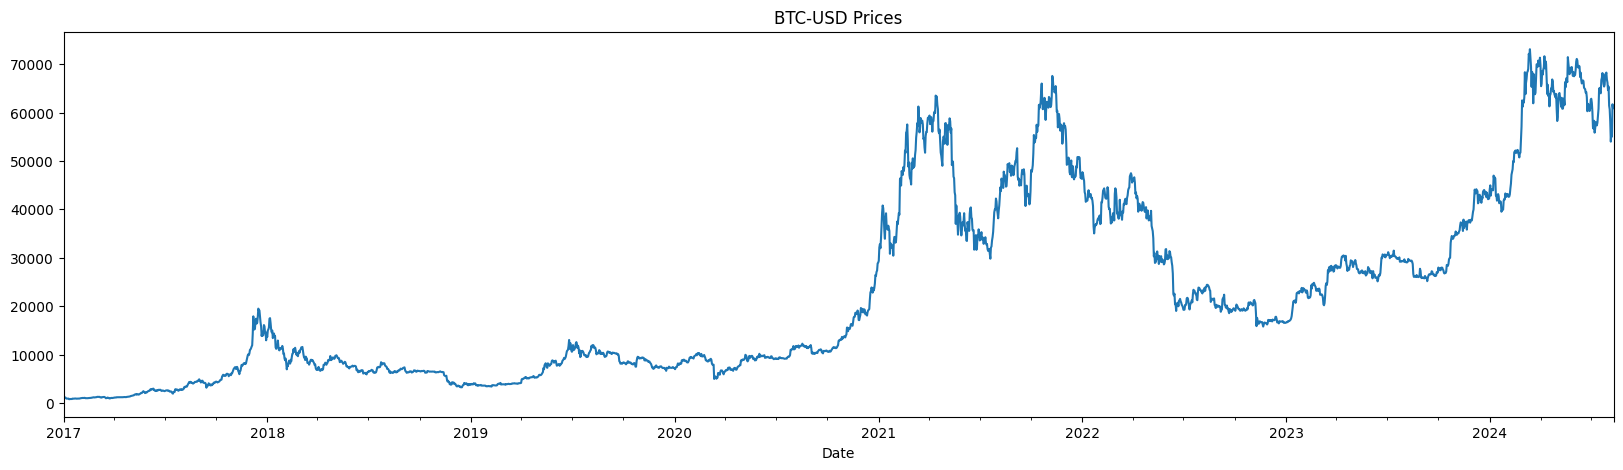

In [26]:
#Graphique
BTC_USD_historical.Close.plot(figsize=(20,5), title = "BTC-USD Prices")
plt.show()

# Preprocessing

In [27]:
BTC_USD_historical_array, BTC_USD_historical.index, scaler,step = normalize_data(df= BTC_USD_historical, columns=['Open','High','Low','Dividends','Stock Splits','Volume'])

Standardisation effectuée


# Make Dataset

In [28]:
X_train,X_test,y_train,y_test= make_dataset(data = BTC_USD_historical_array,pas_temps=2,test_size=0.3)

### Visualisation

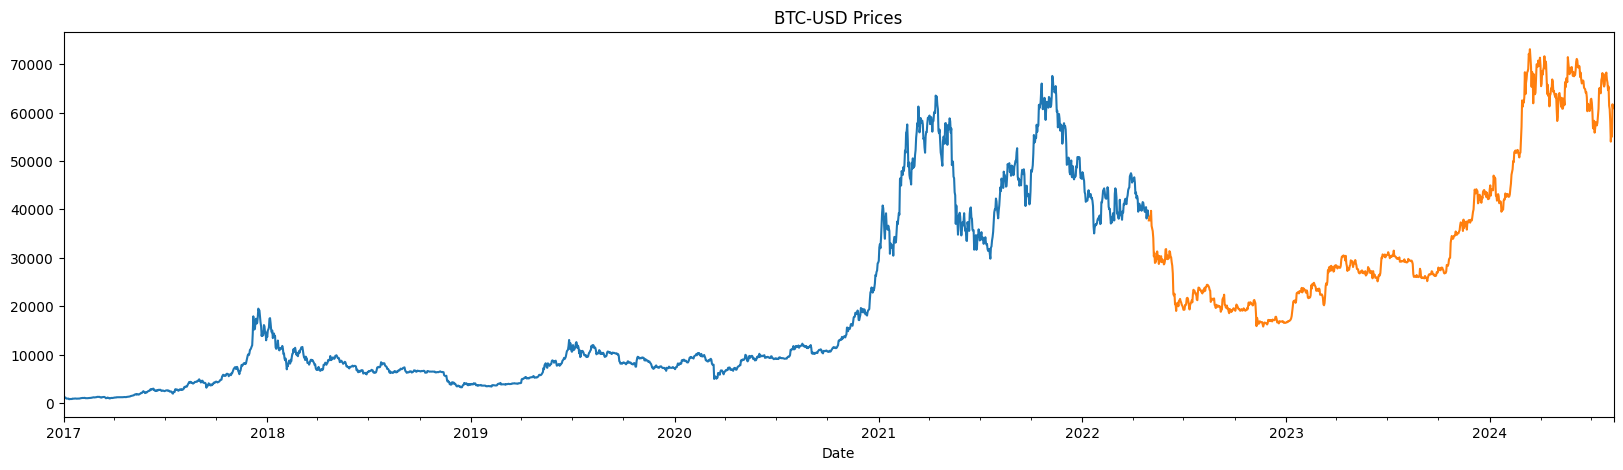

In [29]:
test_size=0.3
size = int(len(BTC_USD_historical)*(1-test_size))

#Tf en df pour la visualisation
train_data_df = BTC_USD_historical[:size]
test_data_df = BTC_USD_historical[size:]

#création d'un tableau d'index temporels
train_index = train_data_df.index
test_index = test_data_df.index

train_data_df.Close.plot(figsize=(20,5), title = "BTC-USD Prices")
test_data_df.Close.plot(figsize=(20,5), title = "BTC-USD Prices")
plt.show()

## Essais

In [30]:
pas_temps = 3
neurons = 250

#Teléchargement via l'API yfinance
BTC_USD = yf.Ticker("BTC-USD")
BTC_USD_historical_array, BTC_USD_historical.index, scaler,step = normalize_data(df= BTC_USD_historical, columns=['Open','High','Low','Dividends','Stock Splits','Volume'])

X_train,X_test,y_train,y_test= make_dataset(data = BTC_USD_historical_array, pas_temps=pas_temps, test_size=0.3)

#training
history, duration_seconds,model = train_LSTM_model(X_train= X_train, y_train=y_train, X_test=X_test, y_test=y_test, batch_size = 10, neurons = neurons, pas_temps = pas_temps)

#prediction
train_predict_valeurs_reelles, y_train_valeurs_reelles, test_predict_valeurs_reelles,y_test_valeurs_reelles = predict(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, scaler=scaler,model=model)

rmse_train, mse_train, mae_train, explained_variance_train, r2_score_train,rmse_test,mse_test,mae_test, explained_variance_test, r2_score_test = evaluate (train_predict_valeurs_reelles = train_predict_valeurs_reelles,
y_train_valeurs_reelles=y_train_valeurs_reelles,
test_predict_valeurs_reelles = test_predict_valeurs_reelles,
y_test_valeurs_reelles = y_test_valeurs_reelles)


Standardisation effectuée


I0000 00:00:1723907563.838129    2482 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-17 17:12:43.838887: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instea


Epoch 7: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 2.
Temps passé pour un pas de temps de 3 jour et un nombre de neurones de 250 : 13.292334 secondes
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


## Visualisation des résultats

pas_temps : 3


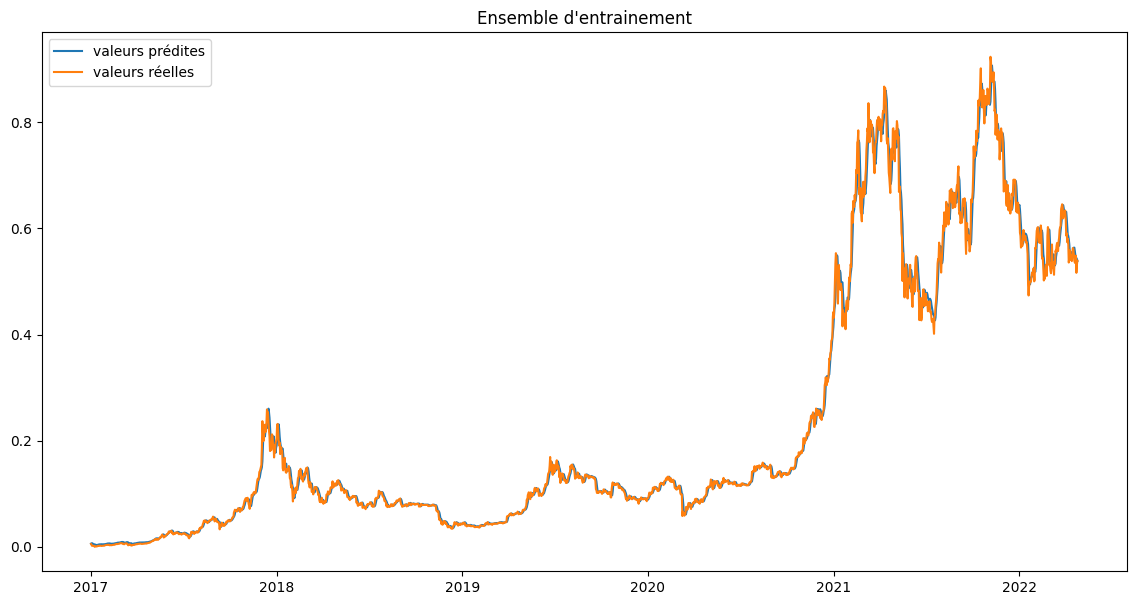

In [31]:
#Plotting
print("pas_temps :", pas_temps)
plt.figure(figsize=(14,7))
plt.plot(train_index[:-(pas_temps+1)],train_predict_valeurs_reelles,label = "valeurs prédites")
plt.plot(train_index[:-(pas_temps+1)],y_train_valeurs_reelles,label = "valeurs réelles")
plt.title("Ensemble d'entrainement")
plt.legend()
plt.show()

pas_temps : 3


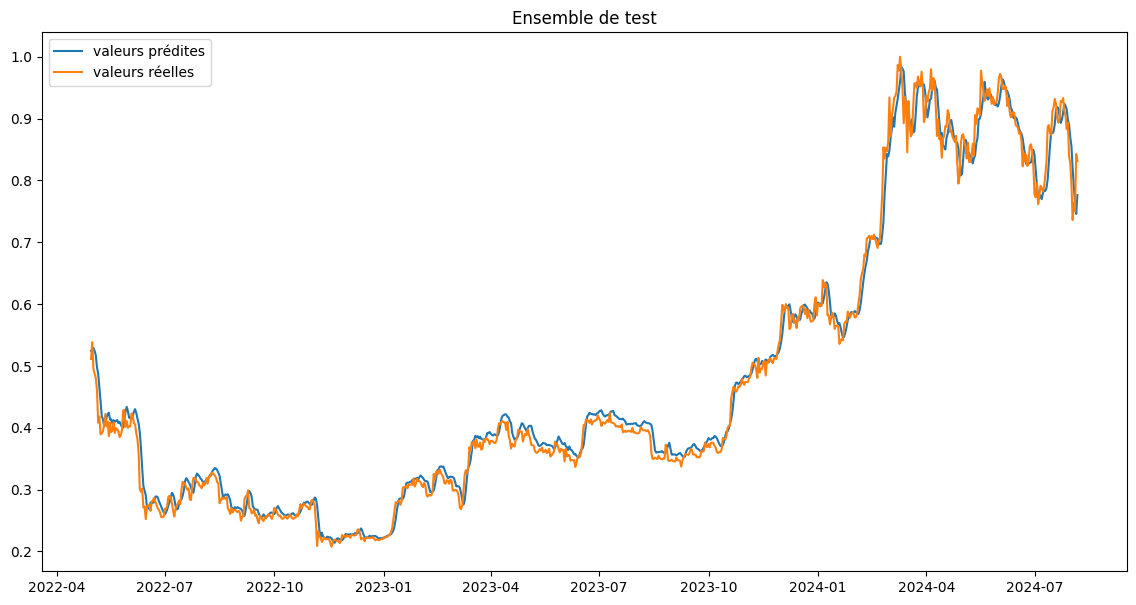

In [32]:
#Plotting
print("pas_temps :", pas_temps)
plt.figure(figsize=(14,7))
plt.plot(test_index[:-(pas_temps+1)],test_predict_valeurs_reelles, label = "valeurs prédites")
#BTC_USD_historical.Close.plot(figsize=(20,5), title = "BTC-USD Prices")
plt.plot(test_index[:-(pas_temps+1)],y_test_valeurs_reelles, label = "valeurs réelles")
plt.title("Ensemble de test")
plt.legend()
plt.show()

pas_temps : 3


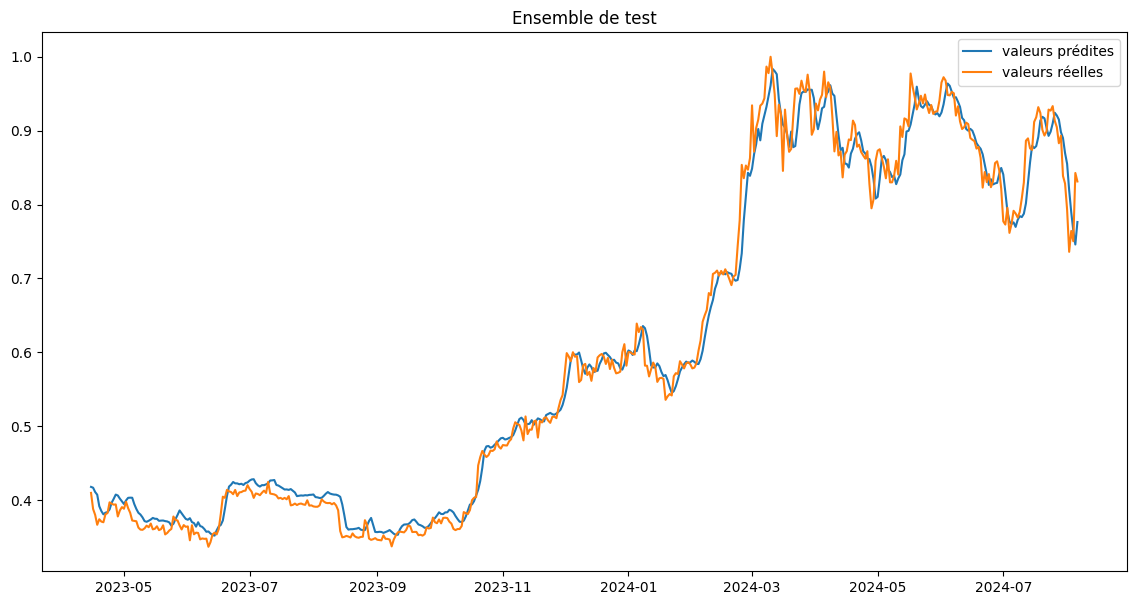

In [33]:
# Visualisation plus fine sur un mois
#Plotting
print("pas_temps :", pas_temps)
plt.figure(figsize=(14,7))
plt.plot(test_index[350:-(pas_temps+1)],test_predict_valeurs_reelles[350:], label = "valeurs prédites")
#BTC_USD_historical.Close.plot(figsize=(20,5), title = "BTC-USD Prices")
plt.plot(test_index[350:-(pas_temps+1)],y_test_valeurs_reelles[350:], label = "valeurs réelles")
plt.title("Ensemble de test")
plt.legend()
plt.show()

Mettre des % en ordonnnée

## Resultats

In [34]:
# Optimisation pas_temps

In [35]:
neurons=100

#Création des listes vides
liste_rmse_train = []
liste_mse_train = []
liste_mae_train = []
liste_rmse_test = []
liste_mse_test = []
liste_mae_test = []
liste_explained_variance_train = []
liste_explained_variance_test = []
liste_r2_score_train = []
liste_r2_score_test= []
liste_duration = []


for pas_temps in range(1,20,1):
    
    #Teléchargement via l'API yfinance
    BTC_USD = yf.Ticker("BTC-USD")
    BTC_USD_historical = BTC_USD.history(start="2017-01-01", end="2024-08-11", interval="1d", auto_adjust = True)
    
    BTC_USD_historical_array, BTC_USD_historical.index, scaler,step = normalize_data(df= BTC_USD_historical, columns=['Open','High','Low','Dividends','Stock Splits','Volume'])
    
    #Data preparation 
    X_train,X_test,y_train,y_test= make_dataset(data = BTC_USD_historical_array, pas_temps=pas_temps, test_size=0.3)
    print("pas_temps :", pas_temps)
    
    
    #training
    history, duration_seconds,model = train_LSTM_model(X_train= X_train, y_train=y_train, X_test=X_test, y_test=y_test, batch_size = 10, neurons = neurons, pas_temps = pas_temps)

    #prediction
    train_predict_valeurs_reelles, y_train_valeurs_reelles, test_predict_valeurs_reelles,y_test_valeurs_reelles = predict(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, scaler=scaler,model=model)

    rmse_train, mse_train, mae_train, explained_variance_train, r2_score_train,rmse_test,mse_test,mae_test, explained_variance_test, r2_score_test = evaluate (train_predict_valeurs_reelles = train_predict_valeurs_reelles,
    y_train_valeurs_reelles=y_train_valeurs_reelles,
    test_predict_valeurs_reelles = test_predict_valeurs_reelles,
    y_test_valeurs_reelles = y_test_valeurs_reelles)

    liste_rmse_train.append(rmse_train)    
    liste_mse_train.append(mse_train)
    liste_mae_train.append(mae_train)
    liste_explained_variance_train.append(explained_variance_train)
    liste_r2_score_train.append(r2_score_train)
    
    liste_rmse_test.append(rmse_test)    
    liste_mse_test.append(mse_test)
    liste_mae_test.append(mae_test)
    liste_explained_variance_test.append(explained_variance_test)
    liste_r2_score_test.append(r2_score_test)  
    

Standardisation effectuée
pas_temps : 1


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 7: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
Temps passé pour un pas de temps de 1 jour et un nombre de neurones de 100 : 6.525322 secondes
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Standardisation effectuée
pas_temps : 2


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 6: ReduceLROnPlateau reducing learning rate to 1e-06.


KeyboardInterrupt: 

/tmp/ipykernel_2440/2981918731.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
/tmp/ipykernel_2440/2981918731.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()
/tmp/ipykernel_2440/2981918731.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[2].legend()


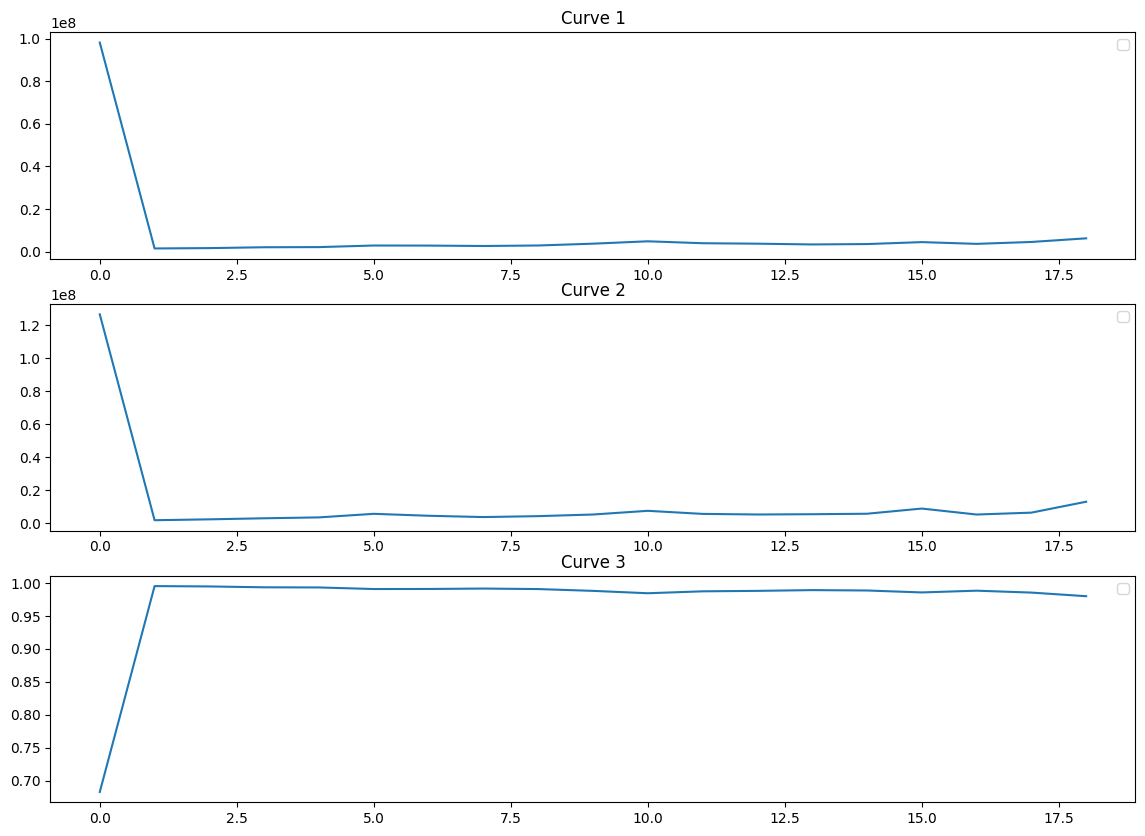

In [ ]:
# Create a figure with two subplots
fig, axs = plt.subplots(3, 1, figsize=(14, 10))

# Plot the first curve on the first subplot
axs[0].plot(liste_mse_train)
axs[0].set_title('Curve 1')

# Plot the second curve on the second subplot
axs[1].plot(liste_mse_test)
axs[1].set_title('Curve 2')

# Plot the third curve on the second subplot
axs[2].plot(liste_r2_score_train)
axs[2].set_title('Curve 3')

# Add a legend to each subplot
axs[0].legend()
axs[1].legend()
axs[2].legend()

# Show the plot
plt.show()



Valeur optimale semble p = 2 par rapport aux métriques

## Optimisation nb neurons

In [ ]:
pas_temps=1

#Création des listes vides
liste_rmse_train = []
liste_mse_train = []
liste_mae_train = []
liste_rmse_test = []
liste_mse_test = []
liste_mae_test = []
liste_explained_variance_train = []
liste_explained_variance_test = []
liste_r2_score_train = []
liste_r2_score_test= []
liste_duration = []

for neurons in range(50,500,50):
    
    #Teléchargement via l'API yfinance
    BTC_USD = yf.Ticker("BTC-USD")
    BTC_USD_historical = BTC_USD.history(start="2017-01-01", end="2024-08-11", interval="1d", auto_adjust = True)
    
    BTC_USD_historical_array, BTC_USD_historical.index, scaler,step = normalize_data(df= BTC_USD_historical, columns=['Open','High','Low','Dividends','Stock Splits','Volume'])
    
    #Data preparation 
    X_train,X_test,y_train,y_test= make_dataset(data = BTC_USD_historical_array, pas_temps=pas_temps, test_size=0.3)
    print("pas_temps :", pas_temps)
    
    
    #training
    history, duration_seconds,model = train_LSTM_model(X_train= X_train, y_train=y_train, X_test=X_test, y_test=y_test, batch_size = 10, neurons = neurons, pas_temps = pas_temps)

    #prediction
    train_predict_valeurs_reelles, y_train_valeurs_reelles, test_predict_valeurs_reelles,y_test_valeurs_reelles = predict(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, scaler=scaler,model=model)

    rmse_train, mse_train, mae_train, explained_variance_train, r2_score_train,rmse_test,mse_test,mae_test, explained_variance_test, r2_score_test = evaluate (train_predict_valeurs_reelles = train_predict_valeurs_reelles,
    y_train_valeurs_reelles=y_train_valeurs_reelles,
    test_predict_valeurs_reelles = test_predict_valeurs_reelles,
    y_test_valeurs_reelles = y_test_valeurs_reelles)

    liste_rmse_train.append(rmse_train)    
    liste_mse_train.append(mse_train)
    liste_mae_train.append(mae_train)
    liste_explained_variance_train.append(explained_variance_train)
    liste_r2_score_train.append(r2_score_train)
    
    liste_rmse_test.append(rmse_test)    
    liste_mse_test.append(mse_test)
    liste_mae_test.append(mae_test)
    liste_explained_variance_test.append(explained_variance_test)
    liste_r2_score_test.append(r2_score_test)     
    

Standardisation effectuée
Séparation des données effectuée:
X_train shape : (1943, 1, 1)
X_test shape : (832, 1, 1)
y_train shape: (1943,)
y_test shape: (832,)
pas_temps : 1


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 8: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
Temps passé pour un pas de temps de 1 jour et un nombre de neurones de 50 : 3.315397 secondes
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
Standardisation effectuée
Séparation des données effectuée:
X_train shape : (1943, 1, 1)
X_test shape : (832, 1, 1)
y_train shape: (1943,)
y_test shape: (832,)
pas_temps : 1


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 7: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
Temps passé pour un pas de temps de 1 jour et un nombre de neurones de 100 : 3.267336 secondes
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
Standardisation effectuée
Séparation des données effectuée:
X_train shape : (1943, 1, 1)
X_test shape : (832, 1, 1)
y_train shape: (1943,)
y_test shape: (832,)
pas_temps : 1


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 7: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
Temps passé pour un pas de temps de 1 jour et un nombre de neurones de 150 : 3.699969 secondes
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
Standardisation effectuée
Séparation des données effectuée:
X_train shape : (1943, 1, 1)
X_test shape : (832, 1, 1)
y_train shape: (1943,)
y_test shape: (832,)
pas_temps : 1


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 7: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
Temps passé pour un pas de temps de 1 jour et un nombre de neurones de 200 : 4.560754 secondes
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
Standardisation effectuée
Séparation des données effectuée:
X_train shape : (1943, 1, 1)
X_test shape : (832, 1, 1)
y_train shape: (1943,)
y_test shape: (832,)
pas_temps : 1


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
Temps passé pour un pas de temps de 1 jour et un nombre de neurones de 250 : 5.1951 secondes
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Standardisation effectuée
Séparation des données effectuée:
X_train shape : (1943, 1, 1)
X_test shape : (832, 1, 1)
y_train shape: (1943,)
y_test shape: (832,)
pas_temps : 1


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 7: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
Temps passé pour un pas de temps de 1 jour et un nombre de neurones de 300 : 5.978413 secondes
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Standardisation effectuée
Séparation des données effectuée:
X_train shape : (1943, 1, 1)
X_test shape : (832, 1, 1)
y_train shape: (1943,)
y_test shape: (832,)
pas_temps : 1


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 7: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
Temps passé pour un pas de temps de 1 jour et un nombre de neurones de 350 : 7.502003 secondes
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Standardisation effectuée
Séparation des données effectuée:
X_train shape : (1943, 1, 1)
X_test shape : (832, 1, 1)
y_train shape: (1943,)
y_test shape: (832,)
pas_temps : 1


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
Temps passé pour un pas de temps de 1 jour et un nombre de neurones de 400 : 9.325318 secondes
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Standardisation effectuée
Séparation des données effectuée:
X_train shape : (1943, 1, 1)
X_test shape : (832, 1, 1)
y_train shape: (1943,)
y_test shape: (832,)
pas_temps : 1


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 7: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
Temps passé pour un pas de temps de 1 jour et un nombre de neurones de 450 : 11.744799 secondes
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/tmp/ipykernel_2440/2071737667.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
/tmp/ipykernel_2440/2071737667.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()
/tmp/ipykernel_2440/2071737667.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[2].legend()


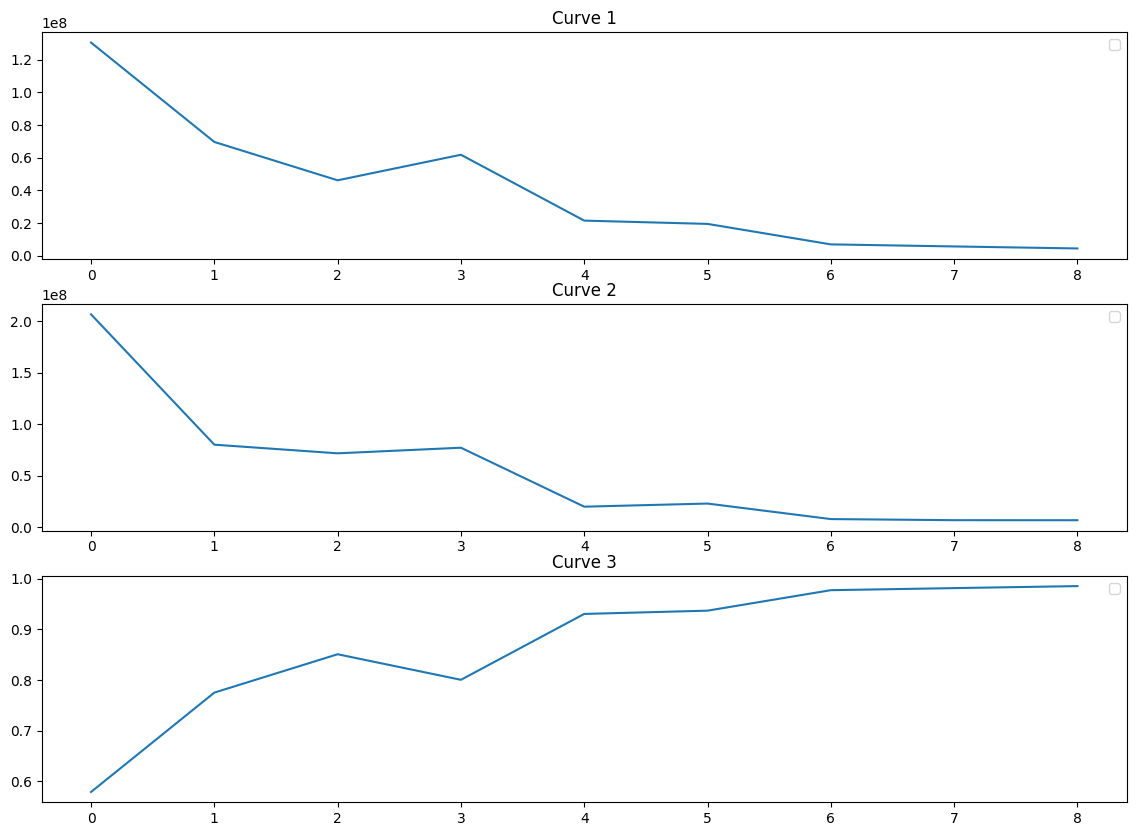

In [ ]:
# Create a figure with two subplots
fig, axs = plt.subplots(3, 1, figsize=(14, 10))

# Plot the first curve on the first subplot
axs[0].plot(liste_mse_train)
axs[0].set_title('Curve 1')

# Plot the second curve on the second subplot
axs[1].plot(liste_mse_test)
axs[1].set_title('Curve 2')

# Plot the third curve on the second subplot
axs[2].plot(liste_r2_score_train)
axs[2].set_title('Curve 3')

# Add a legend to each subplot
axs[0].legend()
axs[1].legend()
axs[2].legend()

# Show the plot
plt.show()


In [ ]:
# 350 neurons semblen le meilleur compris

 # tests Manuels

In [ ]:
# Meilleurs hyperparamètres

pas_temps = 2
neurons = 350

#Teléchargement via l'API yfinance
BTC_USD = yf.Ticker("BTC-USD")
BTC_USD_historical = BTC_USD.history(start="2021-01-01", end="2024-08-09", interval="1d", auto_adjust = True)

# test_size
test_size=0.3
size = int(len(BTC_USD_historical)*(1-test_size))

#Tf en df pour la visualisation
train_data_df = BTC_USD_historical[:size]
test_data_df = BTC_USD_historical[size:]

#création d'un tableau d'index temporels
train_index = train_data_df.index
test_index = test_data_df.index

#Normalizing
BTC_USD_historical_array, BTC_USD_historical.index, scaler,step = normalize_data(df= BTC_USD_historical, columns=['Open','High','Low','Dividends','Stock Splits','Volume'])

#Train and test data split
size = int(len(BTC_USD_historical_array)*(1-test_size))
train_data, test_data = BTC_USD_historical_array[:size,:], BTC_USD_historical_array[size:,:]
    
#Création des ensembles d'entrainement et de la cible en format de séquence:
X_train, y_train = prepare_sequential_data(data=train_data,pas_temps=pas_temps)
X_test, y_test = prepare_sequential_data(data=test_data,pas_temps=pas_temps)

 #mise en forme des données pour le réseau LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)


#construction du model
model = build_lstm_model(neurons=neurons)
    
#entrainement du modèle
history = model.fit(X_train, y_train,
                        batch_size= 10,
                        epochs=100, verbose=1,
                        validation_data = [X_test, y_test],
                        callbacks=[reduce_learning_rate, early_stopping])

#prédiction et remise à l'échelle X
train_predict = model.predict(X_train)
train_predict_valeurs_reelles = train_predict/scaler.scale_[0]


test_predict = model.predict(X_test)
test_predict_valeurs_reelles = test_predict/scaler.scale_[0]

#prédiction et remise à l'échelle y
y_train = y_train.reshape(-1,1)
y_train_valeurs_reelles = y_train /scaler.scale_[0]

y_test = y_test.reshape(-1,1)
y_test_valeurs_reelles = y_test/scaler.scale_[0]

#score train
mse_train = mean_squared_error(y_train_valeurs_reelles,train_predict_valeurs_reelles)
mae_train = mean_absolute_error(y_train_valeurs_reelles,train_predict_valeurs_reelles)
r2_score_train = r2_score(y_train_valeurs_reelles,train_predict_valeurs_reelles)
    
# score test
mse_test = mean_squared_error(y_test_valeurs_reelles,test_predict_valeurs_reelles)
mae_test = mean_absolute_error(y_test_valeurs_reelles,test_predict_valeurs_reelles)
r2_score_test = r2_score(y_test_valeurs_reelles,test_predict_valeurs_reelles)

print("mse train :", mse_train)
print("mae train :", mae_train)
print("r2_score_train :", r2_score_train)
print("mse test :", mse_test)
print("mae train :", mae_test)
print("r2_score_test :", r2_score_test)

Standardisation effectuée
Epoch 1/100


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0689 - mse: 0.0689 - val_loss: 8.1634e-04 - val_mse: 8.1634e-04 - learning_rate: 0.0010
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.9802e-04 - mse: 8.9802e-04 - val_loss: 9.8156e-04 - val_mse: 9.8156e-04 - learning_rate: 0.0010
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.9057e-04 - mse: 8.9057e-04 - val_loss: 0.0012 - val_mse: 0.0012 - learning_rate: 0.0010
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.3429e-04 - mse: 9.3429e-04 - val_loss: 9.4939e-04 - val_mse: 9.4939e-04 - learning_rate: 0.0010
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.9342e-04 - mse: 7.9342e-04 - val_loss: 9.4847e-04 - val_mse: 9.4847e-04 - learning_rate: 0.0010
Epoch 6/100
85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.2878e-04 - mse: 9.2878e-04
Epoch 6: ReduceLROnPlateau reducing learning rate to 1e-06.
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.2000e-04 - mse: 9.2000e-04 - val_loss: 0.0012 

pas_temps : 2


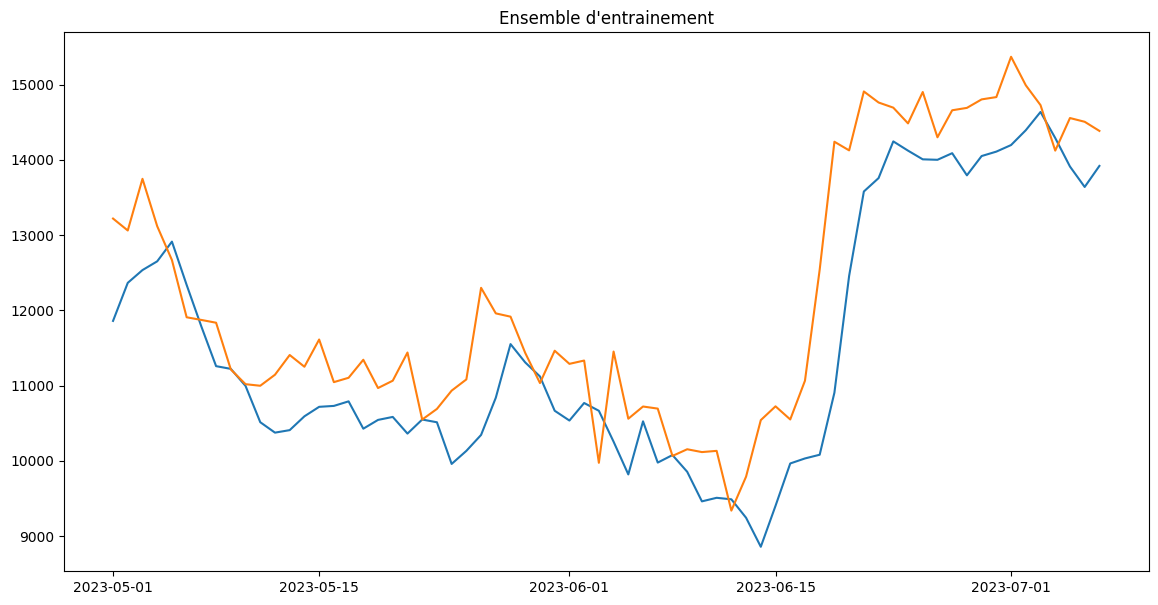

In [ ]:
#Plotting
print("pas_temps :", pas_temps)
plt.figure(figsize=(14,7))
plt.plot(train_index[850:-(pas_temps+1)],train_predict_valeurs_reelles[850:], label = "valeurs prédites")
#BTC_USD_historical.Close.plot(figsize=(20,5), title = "BTC-USD Prices")
plt.plot(train_index[850:-(pas_temps+1)],y_train_valeurs_reelles[850:], label = "valeurs réelles")
plt.title("Ensemble d'entrainement")
plt.show()

pas_temps : 2


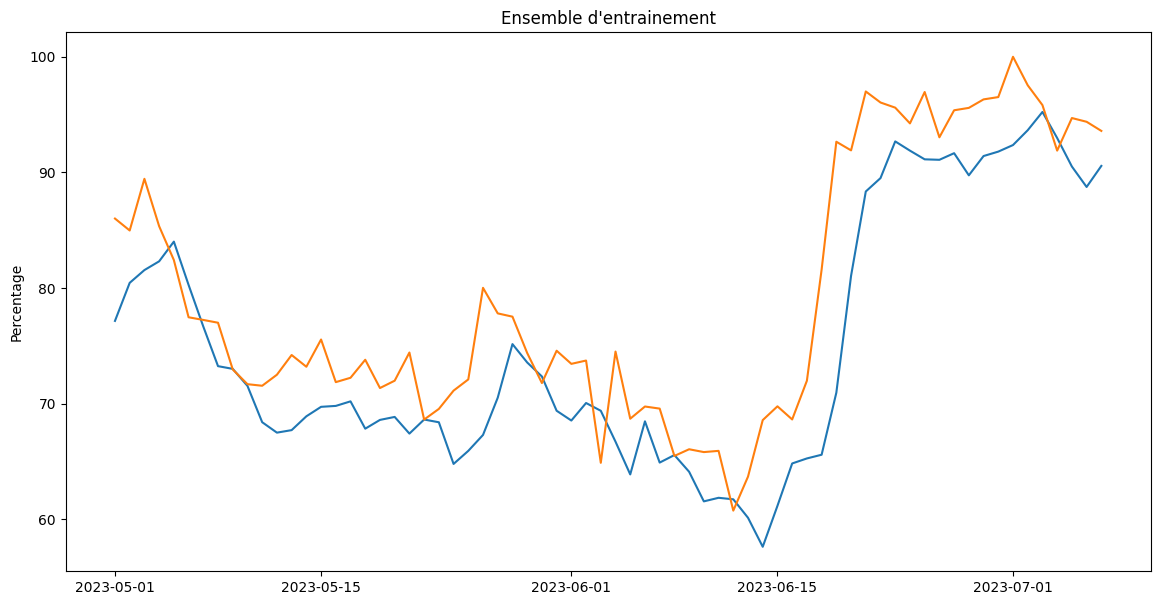

In [ ]:
# Normalize the data
max_value = max(max(train_predict_valeurs_reelles[850:]), max(y_train_valeurs_reelles[850:]))
train_predict_valeurs_reelles_normalized = [(value / max_value) * 100 for value in train_predict_valeurs_reelles[850:]]
y_train_valeurs_reelles_normalized = [(value / max_value) * 100 for value in y_train_valeurs_reelles[850:]]

# Plotting
print("pas_temps :", pas_temps)
plt.figure(figsize=(14,7))
plt.plot(train_index[850:-(pas_temps+1)], train_predict_valeurs_reelles_normalized, label = "valeurs prédites")
plt.plot(train_index[850:-(pas_temps+1)], y_train_valeurs_reelles_normalized, label = "valeurs réelles")
plt.ylabel('Percentage')
plt.title("Ensemble d'entrainement")
plt.show()

pas_temps : 2


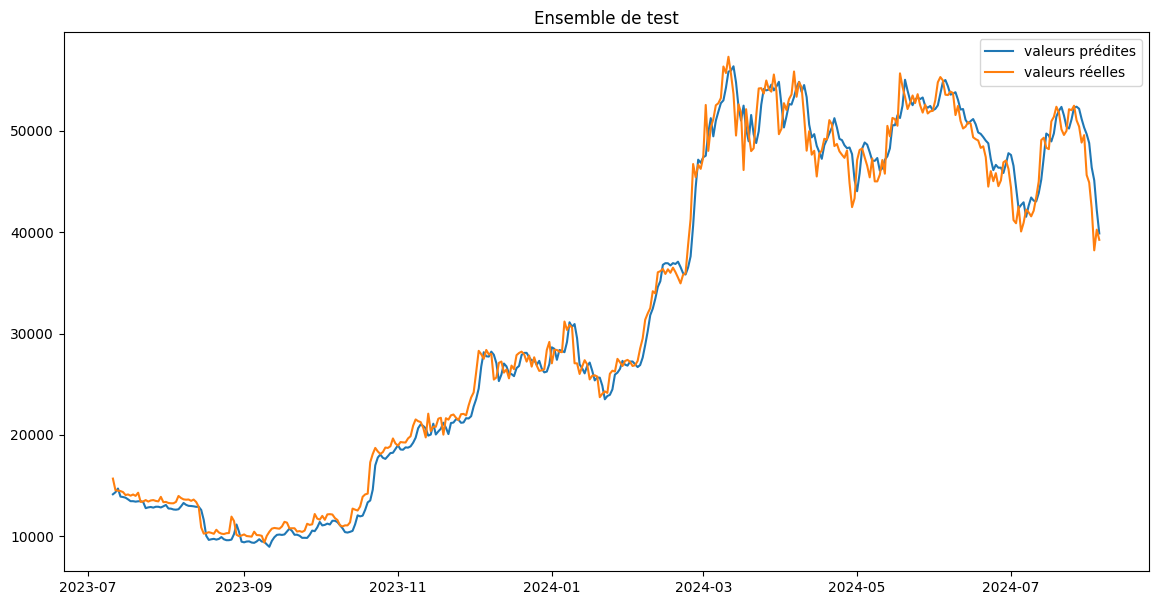

In [ ]:
#Plotting
print("pas_temps :", pas_temps)
plt.figure(figsize=(14,7))
plt.plot(test_index[:-(pas_temps+1)],test_predict_valeurs_reelles, label = "valeurs prédites")
#BTC_USD_historical.Close.plot(figsize=(20,5), title = "BTC-USD Prices")
plt.plot(test_index[:-(pas_temps+1)],y_test_valeurs_reelles, label = "valeurs réelles")
plt.title("Ensemble de test")
plt.legend()
plt.show()

In [ ]:
# En gardant la colonne Volume
pas_temps = 2
neurons = 350

#Teléchargement via l'API yfinance
BTC_USD = yf.Ticker("BTC-USD")
BTC_USD_historical = BTC_USD.history(start="2021-01-01", end="2024-08-09", interval="1d", auto_adjust = True)

# test_size
test_size=0.3
size = int(len(BTC_USD_historical)*(1-test_size))

#Tf en df pour la visualisation
train_data_df = BTC_USD_historical[:size]
test_data_df = BTC_USD_historical[size:]

#création d'un tableau d'index temporels
train_index = train_data_df.index
test_index = test_data_df.index

#Normalizing
BTC_USD_historical_array, BTC_USD_historical.index, scaler,step = normalize_data(df= BTC_USD_historical, columns=['Open','High','Low','Dividends','Stock Splits'])

#Train and test data split
size = int(len(BTC_USD_historical_array)*(1-test_size))
train_data, test_data = BTC_USD_historical_array[:size,:], BTC_USD_historical_array[size:,:]
    
#Création des ensembles d'entrainement et de la cible en format de séquence:
X_train, y_train = prepare_sequential_data(data=train_data,pas_temps=pas_temps)
X_test, y_test = prepare_sequential_data(data=test_data,pas_temps=pas_temps)

 #mise en forme des données pour le réseau LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)


#construction du model
model = build_lstm_model(neurons=neurons)
    
#entrainement du modèle
history = model.fit(X_train, y_train,
                        batch_size= 10,
                        epochs=100, verbose=1,
                        validation_data = [X_test, y_test],
                        callbacks=[reduce_learning_rate, early_stopping])

#prédiction et remise à l'échelle X
train_predict = model.predict(X_train)
train_predict_valeurs_reelles = train_predict/scaler.scale_[0]


test_predict = model.predict(X_test)
test_predict_valeurs_reelles = test_predict/scaler.scale_[0]

#prédiction et remise à l'échelle y
y_train = y_train.reshape(-1,1)
y_train_valeurs_reelles = y_train /scaler.scale_[0]

y_test = y_test.reshape(-1,1)
y_test_valeurs_reelles = y_test/scaler.scale_[0]

#score train
mse_train = mean_squared_error(y_train_valeurs_reelles,train_predict_valeurs_reelles)
mae_train = mean_absolute_error(y_train_valeurs_reelles,train_predict_valeurs_reelles)
r2_score_train = r2_score(y_train_valeurs_reelles,train_predict_valeurs_reelles)
    
# score test
mse_test = mean_squared_error(y_test_valeurs_reelles,test_predict_valeurs_reelles)
mae_test = mean_absolute_error(y_test_valeurs_reelles,test_predict_valeurs_reelles)
r2_score_test = r2_score(y_test_valeurs_reelles,test_predict_valeurs_reelles)

print("mse train :", mse_train)
print("mae train :", mae_train)
print("r2_score_train :", r2_score_train)
print("mse test :", mse_test)
print("mae train :", mae_test)
print("r2_score_test :", r2_score_test)

Standardisation effectuée
Epoch 1/100


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0754 - mse: 0.0754 - val_loss: 9.0708e-04 - val_mse: 9.0708e-04 - learning_rate: 0.0010
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.8083e-04 - mse: 8.8083e-04 - val_loss: 7.3298e-04 - val_mse: 7.3298e-04 - learning_rate: 0.0010
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.8565e-04 - mse: 8.8565e-04 - val_loss: 8.8716e-04 - val_mse: 8.8716e-04 - learning_rate: 0.0010
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.7649e-04 - mse: 7.7649e-04 - val_loss: 0.0014 - val_mse: 0.0014 - learning_rate: 0.0010
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.5178e-04 - mse: 9.5178e-04 - val_loss: 8.1546e-04 - val_mse: 8.1546e-04 - learning_rate: 0.0010
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.5272e-04 - mse: 8.5272e-04 - val_loss: 7.7176e-04 - val_mse: 7.7176e-04 - learning_rate: 0.0010
Epoch 7/100
83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.8405e-04 - mse: 9.8405e-0

pas_temps : 2


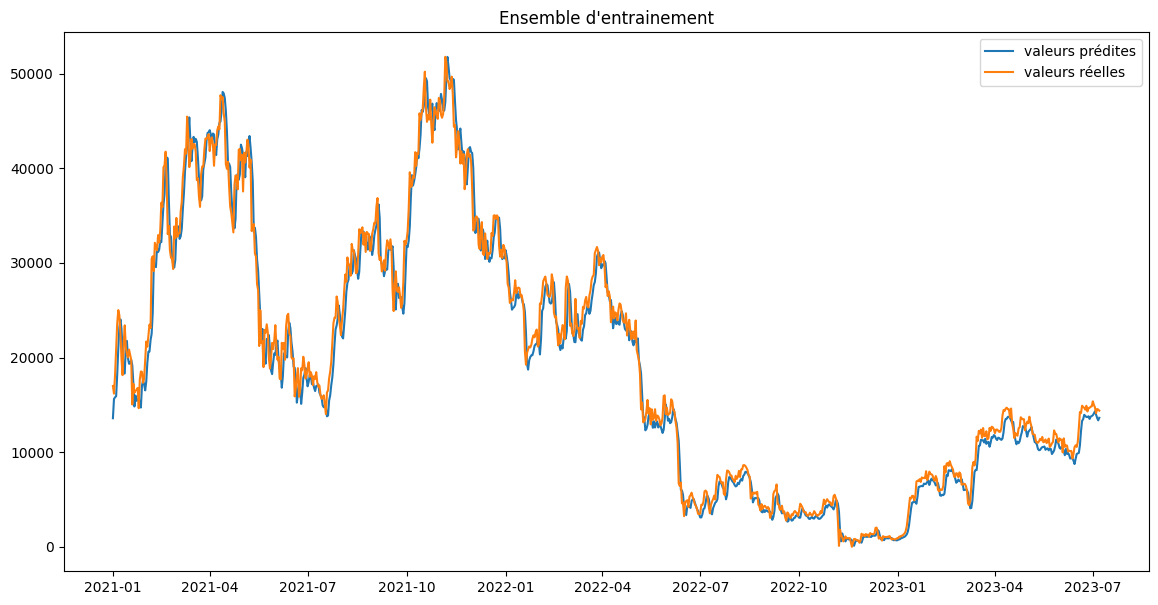

In [ ]:
#Plotting
print("pas_temps :", pas_temps)
plt.figure(figsize=(14,7))
plt.plot(train_index[:-(pas_temps+1)],train_predict_valeurs_reelles,label = "valeurs prédites")
plt.plot(train_index[:-(pas_temps+1)],y_train_valeurs_reelles,label = "valeurs réelles")
plt.title("Ensemble d'entrainement")
plt.legend()
plt.show()

pas_temps : 2


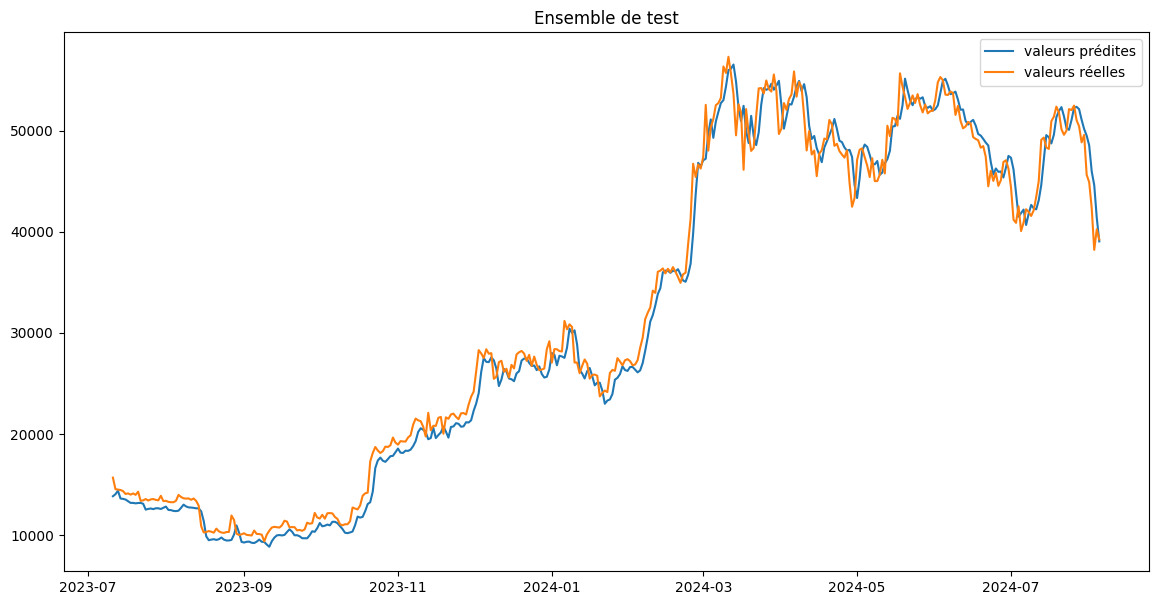

In [ ]:
#Plotting
print("pas_temps :", pas_temps)
plt.figure(figsize=(14,7))
plt.plot(test_index[:-(pas_temps+1)],test_predict_valeurs_reelles, label = "valeurs prédites")
#BTC_USD_historical.Close.plot(figsize=(20,5), title = "BTC-USD Prices")
plt.plot(test_index[:-(pas_temps+1)],y_test_valeurs_reelles, label = "valeurs réelles")
plt.title("Ensemble de test")
plt.legend()
plt.show()

pas_temps : 2


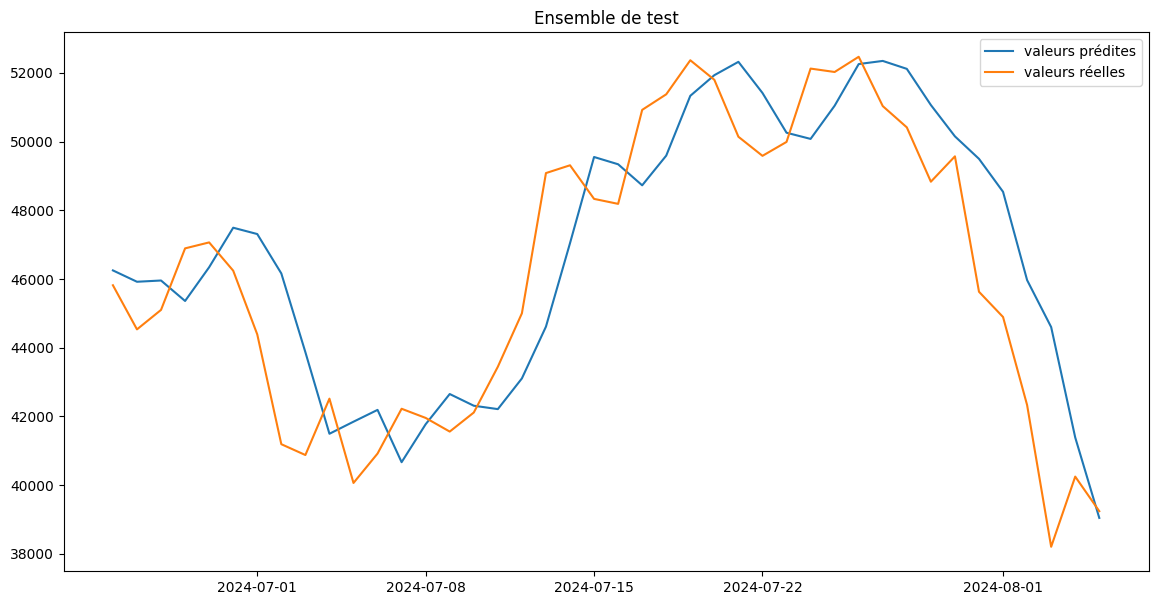

In [ ]:
# Visualisation plus fine sur un mois
#Plotting
print("pas_temps :", pas_temps)
plt.figure(figsize=(14,7))
plt.plot(test_index[350:-(pas_temps+1)],test_predict_valeurs_reelles[350:], label = "valeurs prédites")
#BTC_USD_historical.Close.plot(figsize=(20,5), title = "BTC-USD Prices")
plt.plot(test_index[350:-(pas_temps+1)],y_test_valeurs_reelles[350:], label = "valeurs réelles")
plt.title("Ensemble de test")
plt.legend()
plt.show()

In [ ]:
#AVec le BTC-EUR

# Meilleurs hyperparamètres

pas_temps = 2
neurons = 350

#Teléchargement via l'API yfinance
BTC_USD = yf.Ticker("BTC-EUR")
BTC_USD_historical = BTC_USD.history(start="2021-01-01", end="2024-08-09", interval="1d", auto_adjust = True)

# test_size
test_size=0.3
size = int(len(BTC_USD_historical)*(1-test_size))

#Tf en df pour la visualisation
train_data_df = BTC_USD_historical[:size]
test_data_df = BTC_USD_historical[size:]

#création d'un tableau d'index temporels
train_index = train_data_df.index
test_index = test_data_df.index

#Normalizing
BTC_USD_historical_array, BTC_USD_historical.index, scaler,step = normalize_data(df= BTC_USD_historical, columns=['Open','High','Low','Dividends','Stock Splits','Volume'])

#Train and test data split
size = int(len(BTC_USD_historical_array)*(1-test_size))
train_data, test_data = BTC_USD_historical_array[:size,:], BTC_USD_historical_array[size:,:]
    
#Création des ensembles d'entrainement et de la cible en format de séquence:
X_train, y_train = prepare_sequential_data(data=train_data,pas_temps=pas_temps)
X_test, y_test = prepare_sequential_data(data=test_data,pas_temps=pas_temps)

 #mise en forme des données pour le réseau LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)


#construction du model
model = build_lstm_model(neurons=neurons)
    
#entrainement du modèle
history = model.fit(X_train, y_train,
                        batch_size= 10,
                        epochs=100, verbose=1,
                        validation_data = [X_test, y_test],
                        callbacks=[reduce_learning_rate, early_stopping])

#prédiction et remise à l'échelle X
train_predict = model.predict(X_train)
train_predict_valeurs_reelles = train_predict/scaler.scale_[0]


test_predict = model.predict(X_test)
test_predict_valeurs_reelles = test_predict/scaler.scale_[0]

#prédiction et remise à l'échelle y
y_train = y_train.reshape(-1,1)
y_train_valeurs_reelles = y_train /scaler.scale_[0]

y_test = y_test.reshape(-1,1)
y_test_valeurs_reelles = y_test/scaler.scale_[0]

#score train
mse_train = mean_squared_error(y_train_valeurs_reelles,train_predict_valeurs_reelles)
mae_train = mean_absolute_error(y_train_valeurs_reelles,train_predict_valeurs_reelles)
r2_score_train = r2_score(y_train_valeurs_reelles,train_predict_valeurs_reelles)
    
# score test
mse_test = mean_squared_error(y_test_valeurs_reelles,test_predict_valeurs_reelles)
mae_test = mean_absolute_error(y_test_valeurs_reelles,test_predict_valeurs_reelles)
r2_score_test = r2_score(y_test_valeurs_reelles,test_predict_valeurs_reelles)

print("mse train :", mse_train)
print("mae train :", mae_train)
print("r2_score_train :", r2_score_train)
print("mse test :", mse_test)
print("mae train :", mae_test)
print("r2_score_test :", r2_score_test)

Standardisation effectuée
Epoch 1/100


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0634 - mse: 0.0634 - val_loss: 0.0011 - val_mse: 0.0011 - learning_rate: 0.0010
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.3034e-04 - mse: 7.3034e-04 - val_loss: 0.0014 - val_mse: 0.0014 - learning_rate: 0.0010
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.2415e-04 - mse: 8.2415e-04 - val_loss: 0.0017 - val_mse: 0.0017 - learning_rate: 0.0010
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.4755e-04 - mse: 7.4755e-04 - val_loss: 0.0012 - val_mse: 0.0012 - learning_rate: 0.0010
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.3423e-04 - mse: 8.3423e-04 - val_loss: 0.0014 - val_mse: 0.0014 - learning_rate: 0.0010
Epoch 6/100
87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2494e-04 - mse: 8.2494e-04
Epoch 6: ReduceLROnPlateau reducing learning rate to 1e-06.
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.2414e-04 - mse: 8.2414e-04 - val_loss: 0.0020 - val_mse: 0.0020 - learning_rat

pas_temps : 2


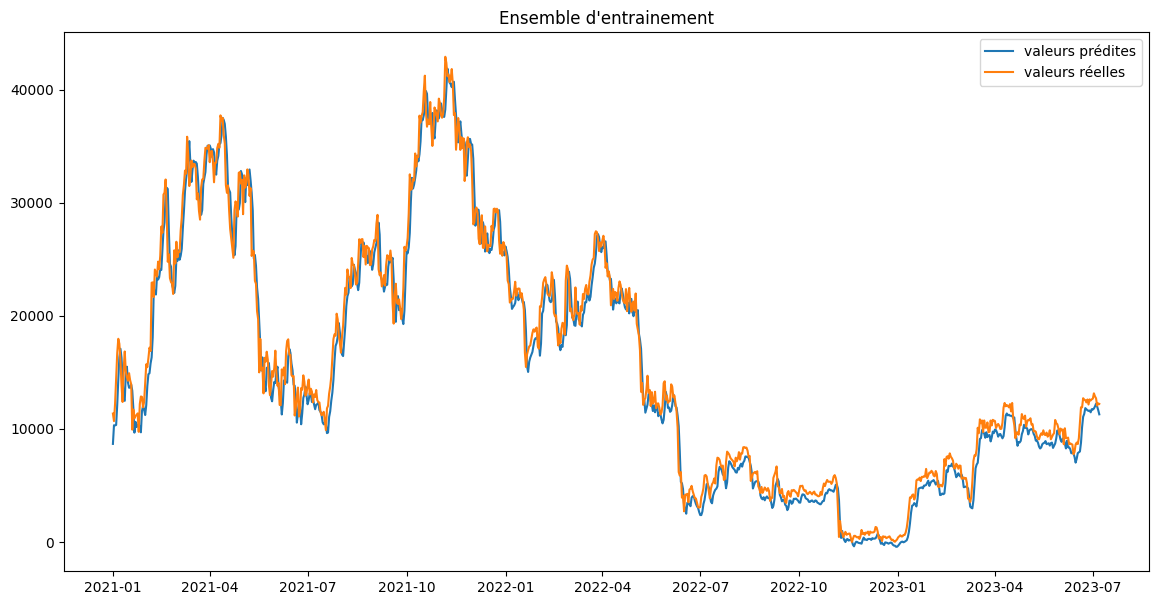

In [ ]:
#Plotting
print("pas_temps :", pas_temps)
plt.figure(figsize=(14,7))
plt.plot(train_index[:-(pas_temps+1)],train_predict_valeurs_reelles,label = "valeurs prédites")
plt.plot(train_index[:-(pas_temps+1)],y_train_valeurs_reelles,label = "valeurs réelles")
plt.title("Ensemble d'entrainement")
plt.legend()
plt.show()

pas_temps : 2


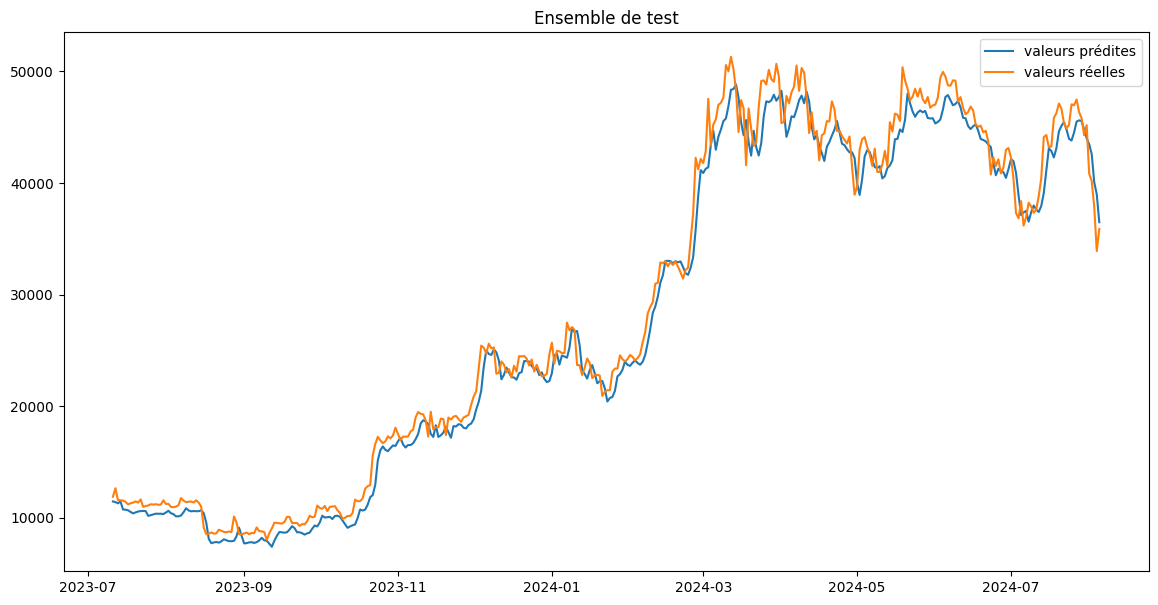

In [ ]:
#Plotting
print("pas_temps :", pas_temps)
plt.figure(figsize=(14,7))
plt.plot(test_index[:-(pas_temps+1)],test_predict_valeurs_reelles, label = "valeurs prédites")
#BTC_USD_historical.Close.plot(figsize=(20,5), title = "BTC-USD Prices")
plt.plot(test_index[:-(pas_temps+1)],y_test_valeurs_reelles, label = "valeurs réelles")
plt.title("Ensemble de test")
plt.legend()
plt.show()

pas_temps : 2


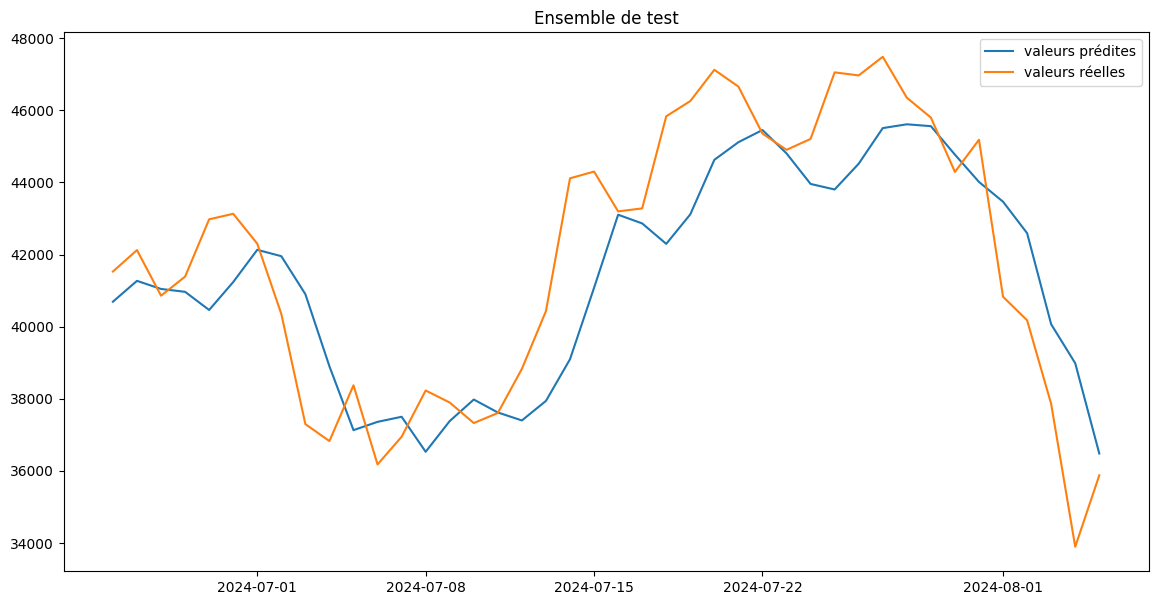

In [ ]:
# Visualisation plus fine sur un mois
#Plotting
print("pas_temps :", pas_temps)
plt.figure(figsize=(14,7))
plt.plot(test_index[350:-(pas_temps+1)],test_predict_valeurs_reelles[350:], label = "valeurs prédites")
#BTC_USD_historical.Close.plot(figsize=(20,5), title = "BTC-USD Prices")
plt.plot(test_index[350:-(pas_temps+1)],y_test_valeurs_reelles[350:], label = "valeurs réelles")
plt.title("Ensemble de test")
plt.legend()
plt.show()

In [36]:
def build_lstm_model(neurons,input_shape = (None,1), activ_func= "linear", loss='mse', metrics= ['mse'], optimizer='adam'):
    """
    Build LSTM model with a given number of neurons and Dense layer for regression prediction
    :param neurons: number of neurons (int>0)
    :param input_shape: Shape of the Input after sequencing of historical prices
    :param activ_func: activation function
    :param loss: loss function used during training
    :param metrics name: metrics showed during training
    :param optimizer: optimizer used during compiling
    :return: LSTM model
    """
    model = Sequential()
    model.add(LSTM(neurons,input_shape=input_shape,activation=activ_func))  
    model.add(Dense(1))
    model.compile(loss=loss, metrics= metrics, optimizer=optimizer)
    return model

In [37]:
# Meilleurs hyperparamètres et activ_func = 'linear'

pas_temps = 2
neurons = 350

#Teléchargement via l'API yfinance
BTC_USD = yf.Ticker("BTC-USD")
BTC_USD_historical = BTC_USD.history(start="2021-01-01", end="2024-08-09", interval="1d", auto_adjust = True)

# test_size
test_size=0.3
size = int(len(BTC_USD_historical)*(1-test_size))

#Tf en df pour la visualisation
train_data_df = BTC_USD_historical[:size]
test_data_df = BTC_USD_historical[size:]

#création d'un tableau d'index temporels
train_index = train_data_df.index
test_index = test_data_df.index

#Normalizing
BTC_USD_historical_array, BTC_USD_historical.index, scaler,step = normalize_data(df= BTC_USD_historical, columns=['Open','High','Low','Dividends','Stock Splits','Volume'])

#Train and test data split
size = int(len(BTC_USD_historical_array)*(1-test_size))
train_data, test_data = BTC_USD_historical_array[:size,:], BTC_USD_historical_array[size:,:]
    
#Création des ensembles d'entrainement et de la cible en format de séquence:
X_train, y_train = prepare_sequential_data(data=train_data,pas_temps=pas_temps)
X_test, y_test = prepare_sequential_data(data=test_data,pas_temps=pas_temps)

 #mise en forme des données pour le réseau LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)


#construction du model
model = build_lstm_model(neurons=neurons)
    
#entrainement du modèle
history = model.fit(X_train, y_train,
                        batch_size= 10,
                        epochs=100, verbose=1,
                        validation_data = [X_test, y_test],
                        callbacks=[reduce_learning_rate, early_stopping])

#prédiction et remise à l'échelle X
train_predict = model.predict(X_train)
train_predict_valeurs_reelles = train_predict/scaler.scale_[0]


test_predict = model.predict(X_test)
test_predict_valeurs_reelles = test_predict/scaler.scale_[0]

#prédiction et remise à l'échelle y
y_train = y_train.reshape(-1,1)
y_train_valeurs_reelles = y_train /scaler.scale_[0]

y_test = y_test.reshape(-1,1)
y_test_valeurs_reelles = y_test/scaler.scale_[0]

#score train
mse_train = mean_squared_error(y_train_valeurs_reelles,train_predict_valeurs_reelles)
mae_train = mean_absolute_error(y_train_valeurs_reelles,train_predict_valeurs_reelles)
r2_score_train = r2_score(y_train_valeurs_reelles,train_predict_valeurs_reelles)
    
# score test
mse_test = mean_squared_error(y_test_valeurs_reelles,test_predict_valeurs_reelles)
mae_test = mean_absolute_error(y_test_valeurs_reelles,test_predict_valeurs_reelles)
r2_score_test = r2_score(y_test_valeurs_reelles,test_predict_valeurs_reelles)

print("mse train :", mse_train)
print("mae train :", mae_train)
print("r2_score_train :", r2_score_train)
print("mse test :", mse_test)
print("mae train :", mae_test)
print("r2_score_test :", r2_score_test)

Standardisation effectuée
Epoch 1/100


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0424 - mse: 0.0424 - val_loss: 0.0017 - val_mse: 0.0017 - learning_rate: 0.0010
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0010 - val_mse: 0.0010 - learning_rate: 0.0010
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.8504e-04 - mse: 9.8504e-04 - val_loss: 9.3458e-04 - val_mse: 9.3458e-04 - learning_rate: 0.0010
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.8408e-04 - mse: 8.8408e-04 - val_loss: 8.6890e-04 - val_mse: 8.6890e-04 - learning_rate: 0.0010
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.3194e-04 - mse: 9.3194e-04 - val_loss: 8.5996e-04 - val_mse: 8.5996e-04 - learning_rate: 0.0010
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.8840e-04 - mse: 9.8840e-04 - val_loss: 9.4401e-04 - val_mse: 9.4401e-04 - learning_rate: 0.0010
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 8.8

pas_temps : 2


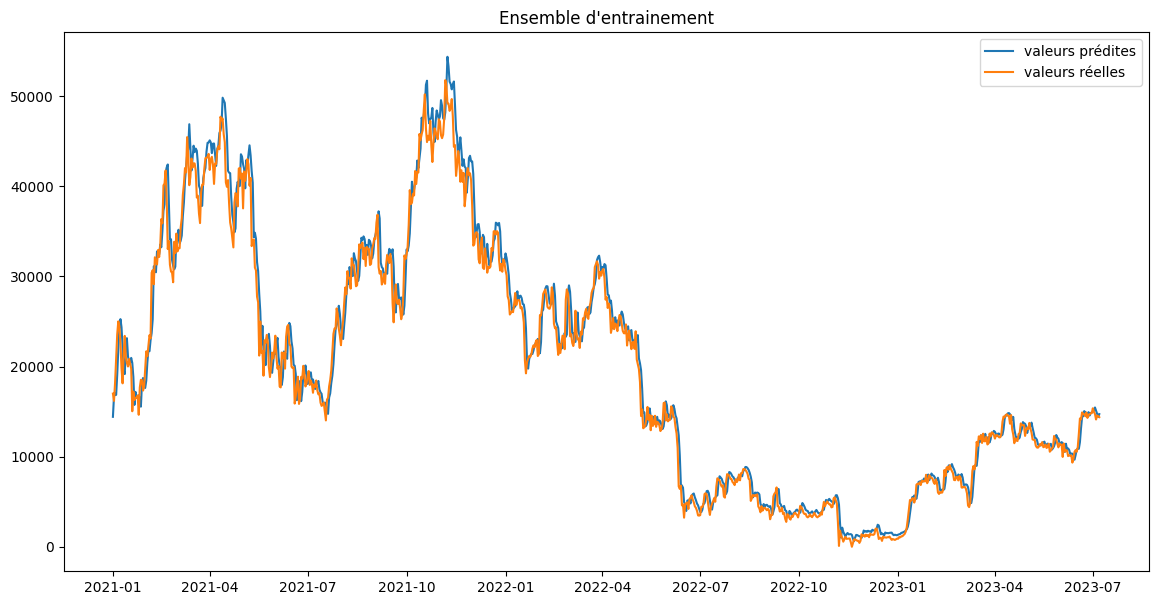

In [38]:
#Plotting
print("pas_temps :", pas_temps)
plt.figure(figsize=(14,7))
plt.plot(train_index[:-(pas_temps+1)],train_predict_valeurs_reelles,label = "valeurs prédites")
plt.plot(train_index[:-(pas_temps+1)],y_train_valeurs_reelles,label = "valeurs réelles")
plt.title("Ensemble d'entrainement")
plt.legend()
plt.show()

pas_temps : 2


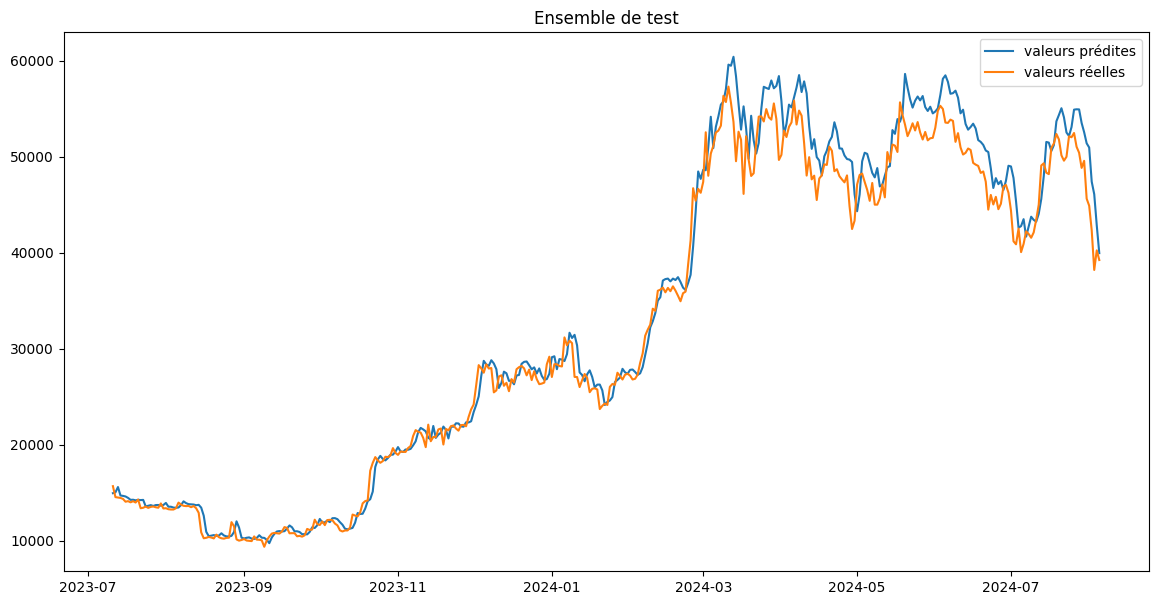

In [39]:
#Plotting
print("pas_temps :", pas_temps)
plt.figure(figsize=(14,7))
plt.plot(test_index[:-(pas_temps+1)],test_predict_valeurs_reelles, label = "valeurs prédites")
#BTC_USD_historical.Close.plot(figsize=(20,5), title = "BTC-USD Prices")
plt.plot(test_index[:-(pas_temps+1)],y_test_valeurs_reelles, label = "valeurs réelles")
plt.title("Ensemble de test")
plt.legend()
plt.show()

pas_temps : 2


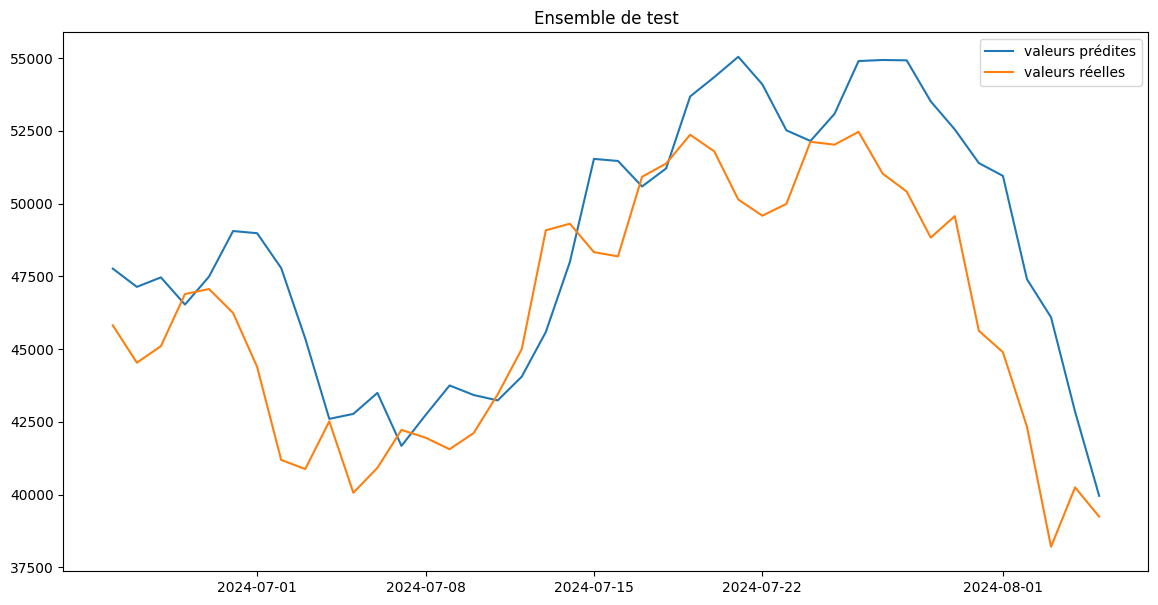

In [40]:
# Visualisation plus fine sur un mois
#Plotting
print("pas_temps :", pas_temps)
plt.figure(figsize=(14,7))
plt.plot(test_index[350:-(pas_temps+1)],test_predict_valeurs_reelles[350:], label = "valeurs prédites")
#BTC_USD_historical.Close.plot(figsize=(20,5), title = "BTC-USD Prices")
plt.plot(test_index[350:-(pas_temps+1)],y_test_valeurs_reelles[350:], label = "valeurs réelles")
plt.title("Ensemble de test")
plt.legend()
plt.show()

In [ ]:
Résultats moin bons

In [43]:
def train_LSTM_model(X_train, y_train, X_test, y_test, neurons, pas_temps, batch_size = 5):
    """
    """ 
    # Enregistrer l'heure de début
    start_time = datetime.datetime.now()
    
    #construction du model
    model = build_lstm_model(neurons=neurons)
    
    #entrainement du modèle
    history = model.fit(X_train, y_train,
                        batch_size= 10,
                        epochs=100, verbose=0,
                        validation_data = [X_test, y_test],
                        callbacks=[reduce_learning_rate, early_stopping])
   
    # Enregistrer l'heure de fin
    end_time = datetime.datetime.now()
    # Calculer la durée
    duration = end_time - start_time
    duration_seconds = duration.total_seconds()
    
    # Afficher la durée
    print(f"Temps passé pour un pas de temps de {pas_temps} jour et un nombre de neurones de {neurons} :", duration_seconds, "secondes")
        
    return history,duration_seconds,model
    
    

# Meilleurs hyperparamètres et variation de batch-size

pas_temps = 2
neurons = 350

#Teléchargement via l'API yfinance
BTC_USD = yf.Ticker("BTC-USD")
BTC_USD_historical = BTC_USD.history(start="2021-01-01", end="2024-08-09", interval="1d", auto_adjust = True)

# test_size
test_size=0.3
size = int(len(BTC_USD_historical)*(1-test_size))

#Tf en df pour la visualisation
train_data_df = BTC_USD_historical[:size]
test_data_df = BTC_USD_historical[size:]

#création d'un tableau d'index temporels
train_index = train_data_df.index
test_index = test_data_df.index

#Normalizing
BTC_USD_historical_array, BTC_USD_historical.index, scaler,step = normalize_data(df= BTC_USD_historical, columns=['Open','High','Low','Dividends','Stock Splits','Volume'])

#Train and test data split
size = int(len(BTC_USD_historical_array)*(1-test_size))
train_data, test_data = BTC_USD_historical_array[:size,:], BTC_USD_historical_array[size:,:]
    
#Création des ensembles d'entrainement et de la cible en format de séquence:
X_train, y_train = prepare_sequential_data(data=train_data,pas_temps=pas_temps)
X_test, y_test = prepare_sequential_data(data=test_data,pas_temps=pas_temps)

 #mise en forme des données pour le réseau LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)


#construction du model
model = build_lstm_model(neurons=neurons)
    
#entrainement du modèle
history = model.fit(X_train, y_train,
                        batch_size= 10,
                        epochs=100, verbose=1,
                        validation_data = [X_test, y_test],
                        callbacks=[reduce_learning_rate, early_stopping])

#prédiction et remise à l'échelle X
train_predict = model.predict(X_train)
train_predict_valeurs_reelles = train_predict/scaler.scale_[0]


test_predict = model.predict(X_test)
test_predict_valeurs_reelles = test_predict/scaler.scale_[0]

#prédiction et remise à l'échelle y
y_train = y_train.reshape(-1,1)
y_train_valeurs_reelles = y_train /scaler.scale_[0]

y_test = y_test.reshape(-1,1)
y_test_valeurs_reelles = y_test/scaler.scale_[0]

#score train
mse_train = mean_squared_error(y_train_valeurs_reelles,train_predict_valeurs_reelles)
mae_train = mean_absolute_error(y_train_valeurs_reelles,train_predict_valeurs_reelles)
r2_score_train = r2_score(y_train_valeurs_reelles,train_predict_valeurs_reelles)
    
# score test
mse_test = mean_squared_error(y_test_valeurs_reelles,test_predict_valeurs_reelles)
mae_test = mean_absolute_error(y_test_valeurs_reelles,test_predict_valeurs_reelles)
r2_score_test = r2_score(y_test_valeurs_reelles,test_predict_valeurs_reelles)

print("mse train :", mse_train)
print("mae train :", mae_train)
print("r2_score_train :", r2_score_train)
print("mse test :", mse_test)
print("mae train :", mae_test)
print("r2_score_test :", r2_score_test)

Standardisation effectuée
Epoch 1/100


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0404 - mse: 0.0404 - val_loss: 0.0012 - val_mse: 0.0012 - learning_rate: 0.0010
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0010 - val_mse: 0.0010 - learning_rate: 0.0010
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 9.4870e-04 - val_mse: 9.4870e-04 - learning_rate: 0.0010
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0014 - val_mse: 0.0014 - learning_rate: 0.0010
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.1757e-04 - mse: 9.1757e-04 - val_loss: 0.0010 - val_mse: 0.0010 - learning_rate: 0.0010
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.2545e-04 - mse: 9.2545e-04 - val_loss: 0.0016 - val_mse: 0.0016 - learning_rate: 0.0010
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 8.2032e-04 - val_mse: 8.2032e-04 - learning_rate:

In [ ]:
# mse ok

pas_temps : 2


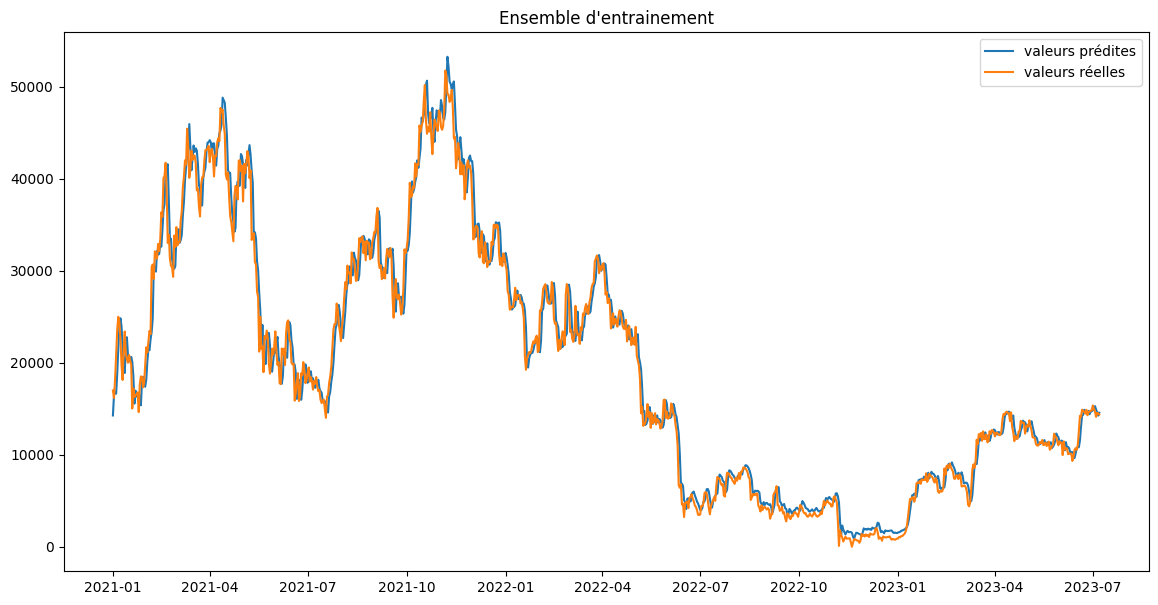

In [44]:
#Plotting
print("pas_temps :", pas_temps)
plt.figure(figsize=(14,7))
plt.plot(train_index[:-(pas_temps+1)],train_predict_valeurs_reelles,label = "valeurs prédites")
plt.plot(train_index[:-(pas_temps+1)],y_train_valeurs_reelles,label = "valeurs réelles")
plt.title("Ensemble d'entrainement")
plt.legend()
plt.show()

pas_temps : 2


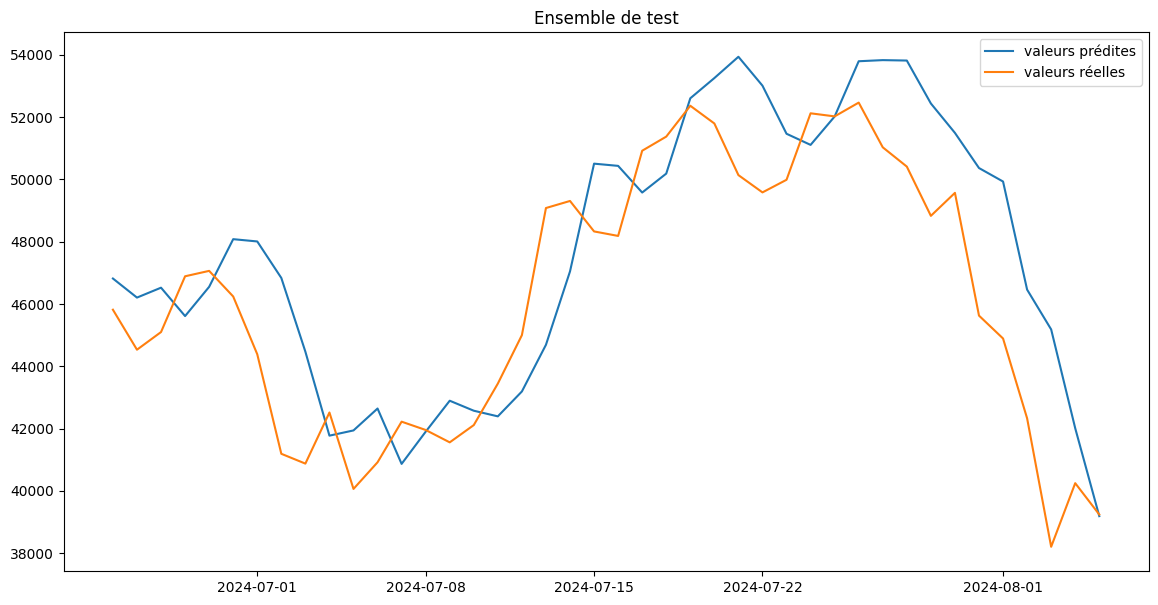

In [45]:
# Visualisation plus fine sur un mois
#Plotting
print("pas_temps :", pas_temps)
plt.figure(figsize=(14,7))
plt.plot(test_index[350:-(pas_temps+1)],test_predict_valeurs_reelles[350:], label = "valeurs prédites")
#BTC_USD_historical.Close.plot(figsize=(20,5), title = "BTC-USD Prices")
plt.plot(test_index[350:-(pas_temps+1)],y_test_valeurs_reelles[350:], label = "valeurs réelles")
plt.title("Ensemble de test")
plt.legend()
plt.show()

In [19]:
  

# Meilleurs hyperparamètres et variation de batch-size

pas_temps = 2
neurons = 350

#Teléchargement via l'API yfinance
BTC_USD = yf.Ticker("BTC-USD")
BTC_USD_historical = BTC_USD.history(start="2021-01-01", end="2024-08-09", interval="5d", auto_adjust = True)

# test_size
test_size=0.3
size = int(len(BTC_USD_historical)*(1-test_size))

#Tf en df pour la visualisation
train_data_df = BTC_USD_historical[:size]
test_data_df = BTC_USD_historical[size:]

#création d'un tableau d'index temporels
train_index = train_data_df.index
test_index = test_data_df.index

#Normalizing
BTC_USD_historical_array, BTC_USD_historical.index, scaler,step = normalize_data(df= BTC_USD_historical, columns=['Open','High','Low','Volume'])

#Train and test data split
size = int(len(BTC_USD_historical_array)*(1-test_size))
train_data, test_data = BTC_USD_historical_array[:size,:], BTC_USD_historical_array[size:,:]
    
#Création des ensembles d'entrainement et de la cible en format de séquence:
X_train, y_train = prepare_sequential_data(data=train_data,pas_temps=pas_temps)
X_test, y_test = prepare_sequential_data(data=test_data,pas_temps=pas_temps)

 #mise en forme des données pour le réseau LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)


#construction du model
model = build_lstm_model(neurons=neurons)
    
#entrainement du modèle
history = model.fit(X_train, y_train,
                        batch_size= 10,
                        epochs=100, verbose=1,
                        validation_data = [X_test, y_test],
                        callbacks=[reduce_learning_rate, early_stopping])

#prédiction et remise à l'échelle X
train_predict = model.predict(X_train)
train_predict_valeurs_reelles = train_predict/scaler.scale_[0]


test_predict = model.predict(X_test)
test_predict_valeurs_reelles = test_predict/scaler.scale_[0]

#prédiction et remise à l'échelle y
y_train = y_train.reshape(-1,1)
y_train_valeurs_reelles = y_train /scaler.scale_[0]

y_test = y_test.reshape(-1,1)
y_test_valeurs_reelles = y_test/scaler.scale_[0]

#score train
mse_train = mean_squared_error(y_train_valeurs_reelles,train_predict_valeurs_reelles)
mae_train = mean_absolute_error(y_train_valeurs_reelles,train_predict_valeurs_reelles)
r2_score_train = r2_score(y_train_valeurs_reelles,train_predict_valeurs_reelles)
    
# score test
mse_test = mean_squared_error(y_test_valeurs_reelles,test_predict_valeurs_reelles)
mae_test = mean_absolute_error(y_test_valeurs_reelles,test_predict_valeurs_reelles)
r2_score_test = r2_score(y_test_valeurs_reelles,test_predict_valeurs_reelles)

print("mse train :", mse_train)
print("mae train :", mae_train)
print("r2_score_train :", r2_score_train)
print("mse test :", mse_test)
print("mae train :", mae_test)
print("r2_score_test :", r2_score_test)

Standardisation effectuée
Epoch 1/100


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1478 - mse: 0.1478 - val_loss: 0.1587 - val_mse: 0.1587 - learning_rate: 0.0010
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0452 - mse: 0.0452 - val_loss: 0.0203 - val_mse: 0.0203 - learning_rate: 0.0010
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0167 - mse: 0.0167 - val_loss: 0.0184 - val_mse: 0.0184 - learning_rate: 0.0010
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0042 - val_mse: 0.0042 - learning_rate: 0.0010
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0060 - val_mse: 0.0060 - learning_rate: 0.0010
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0066 - val_mse: 0.0066 - learning_rate: 0.0010
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0042 - val_mse: 0.0042 - learning_rate: 0.0010
Epoch 8/100
19/19 ━━━━━━